# Various visualisations of the DSMC Pi results

# Buffon's needle experiment

## Introduction

This notebook is a variation of `DSMCPi_AsymptoticAnalysis` created to merge 3 datasets (3 workflow runs) into one and consider the assay averages for each.

The following directories/workflow runs are considered:

- PRNG
    - `asymptoticAssay_buffon_pPRNG_mrg5s`
    - `asymptoticAssay_buffon_pPRNG_mrg5s_ReRun1`
    - `asymptoticAssay_buffon_pPRNG_mrg5s_ReRun2`
- QRNG
    - `asymptoticAssay_buffon_QRNG_errorfixed`
    - `asymptoticAssay_buffon_QRNG_errorfixed_2`
    - `asymptoticAssay_buffon_QRNG_errorfixed_NETDEVICE`
    
Each workflow consists of 10 assays with number of batches, repetitions per batch and samples on the appropriate 2D domain defined in [a section below](Define_parameters_and_load_the_data).

## Warnings

A few of the sections within this notebook are parallelised using either Pythons `multiprocessing` package or [Numba](http://numba.pydata.org). In spite of this they may result in exceedingly long run times and may be skipped if the results are of no particular interest. These sections are
- [Correlation analysis](#Correlation-analysis)
- [Roundoff error analysis](#Roundoff-error-analysis)
- [Permutation of the datasets to obtain a mean of means](#Permutation-of-the-datasets-to-obtain-a-mean-of-means)

## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
import os, shutil, sys, re

In [2]:
import matplotlib as mpl

In [3]:
from scipy import stats

In [4]:
from multiprocessing import Pool

In [5]:
import gc

In [6]:
import itertools

In some computationally intensive evaluations we utilise [Numba](https://numba.pydata.org/) to parallelise and speed-up the calculations. We **do not** use Numba to offload calculations onto a GPU.
Sections listed in the [Warnings](#Warnings) section above generally require Numba to be present. Since these sections are **not** essential to the reproduction of the plots provided in the paper they can be safely neglected!

In [7]:
import numba as nb

Define a figure size to be used for plots with a single figure.

In [8]:
figsize=(6,5)

## Helper functions

In the following we define functions that will be useful in the evaluation of the data.

In [9]:
def consecutive(data, stepsize=1):
    """
    Code to determine the chunks of an index array with consecutive indices. As suggested at:
    https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [10]:
def normhist(samples, numBins=None):
    # choice of the number of bins if none provided
    if numBins is None:
        numBins = int( np.ceil(1 + np.log2( len(samples) )) )
    # normalising factor
    normFactor = numBins / len(samples) * 1 / (samples.max() - samples.min())
    binCounts, binEdges = np.histogram(samples, bins=numBins)
    binCentres = (binEdges[1:] + binEdges[:-1])/2
    errorbars = np.sqrt( binCounts )
    return (normFactor * binCounts, binCentres, binEdges, errorbars * normFactor)

In [11]:
#function providing a normalised histogram with errorbars
def normalisedHistWithErrorbars(data, bins):
    """
    The function accepts a dataset and a 'bins' argument
    in a way identical to NumPy's `histogram` function.
    It returns:
    histValues - histogram values
    binCentres - centers of the histogram bins
    binEdges - edges of the histogram bins
    errorbars - errorbar values according to the Poisson distribution
    """
    histNormFactor = bins / len(data) * 1 / (data.max() - data.min())
    histValues, binEdges = np.histogram(data, bins=bins)
    binCentres = (binEdges[:-1] + binEdges[1:])/2
    errorbars = np.sqrt( histValues )
    return (histValues * histNormFactor, binCentres, binEdges, errorbars * histNormFactor)

## Define parameters and load the data for the Buffon's needle experiment

### Preparations

First we define the assay parameters along with the directories for QRNG and PRNG data

In [12]:
# workflow, asymptotic analysis, used only as a reminder in this notebook!
Nbatches=[4, 8, 16, 32, 64, 128, 256]
Nrep=[10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
Nsamples=[int(i) for i in [10000, 100000] ]

NumAssays=10

NumWorkflows = 3

Change into the directory of the QRNG experiments

### Read the data in

In [13]:
#parallel runs, QRNG
qrngData1 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_QRNG_errorfixed/run/rawSamples_parallel_asymptotic_single_QRNG.csv", index_col=0)
qrngData2 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_QRNG_errorfixed_2/run/rawSamples_parallel_asymptotic_single_QRNG.csv", index_col=0)
qrngData3 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_QRNG_errorfixed_NETDEVICE/run/rawSamples_parallel_asymptotic_single_QRNG.csv", index_col=0)
#M=1k samples per point 
qrngData1k = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/buffonNeedle_2/run/rawSamples_parallel_single_QRNG_buffon.csv", index_col=0)
#Single program launch single thread (sequential)
qrngDataSST = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_QRNG_errorfixed_NETDEVICE_FS_ST/run/rawSamples_parallel_asymptotic_single_QRNG.csv", index_col=0)

In [14]:
#parallel PRNG (MRG5s generator)
prngData1 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_pPRNG_mrg5s/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
prngData2 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_pPRNG_mrg5s_ReRun1/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
prngData3 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_pPRNG_mrg5s_ReRun2/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
#MINSTD0 RNG, multiple runs multiple threads
prngDataD1 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_PRNG_default/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
prngDataD2 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_PRNG_default2/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
prngDataD3 = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_PRNG_default3/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)

# M=1k samples per point
prngData1k = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/parallelPRNG_blockSplitting_buffon/run/rawSamples_parallel_single_pPRNG_buffon_subset.csv", index_col=0)

#MINSTD0 RNG, single program launch (single seed)
prngDataDs = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_PRNG_default_singlerun/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
# + single thread (sequential)
prngDataDsst = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_PRNG_default_singlerun_ST/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)
# Parallel PRNG, single seed single thread (sequential)
prngDataSST = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/asymptoticAssay_buffon_pPRNG_mrg5s_FS_ST/run/rawSamples_parallel_asymptotic_single_pPRNG.csv", index_col=0)

In [15]:
# join the data
qrngData = pd.concat([qrngData1, qrngData2, qrngData3])

prngData = pd.concat([prngData1, prngData2, prngData3])

prngDataD = pd.concat([prngDataD1, prngDataD2, prngDataD3])

In [16]:
qrngData.reset_index(inplace=True)
prngData.reset_index(inplace=True)
prngDataD.reset_index(inplace=True)

qrngData.drop("index", axis=1, inplace=True)
prngData.drop("index", axis=1, inplace=True)
prngDataD.drop("index", axis=1, inplace=True)

re-batching and batch calculations

In [17]:
qrngData.head()

,10000,100000
0,3.13725,3.13401
1,3.12842,3.13249
2,3.14367,3.14470
3,3.15457,3.14460
4,3.13578,3.14312


In [18]:
prngData.head()

,10000,100000
0,3.16206,3.12999
1,3.16106,3.13834
2,3.11429,3.15667
3,3.14268,3.14095
4,3.14515,3.14204


Define the variable that allows us to select the proper column of the dataset

In [19]:
qrngData.columns

Index(['10000', '100000'], dtype='object')

In [20]:
samplesOnUnitSquare = '100000'

In [21]:
N = qrngData.shape[0]

Split the dataset into groups of values corresponding to individual assays

In [22]:
numGroups = NumAssays * NumWorkflows

In [23]:
qrng = qrngData[samplesOnUnitSquare].to_numpy()
partQrng = np.split(qrng, numGroups)

In [24]:
case1_means = np.average(partQrng ,axis=1)

In [25]:
prng = prngData[samplesOnUnitSquare].to_numpy()
partPrng = np.split(prng, numGroups)

In [26]:
prngcase1_means = np.average(partPrng ,axis=1)

## Correlation analysis

**WARNING** The calculations in this section are exceedingly long and memory consuming!

In this section of the notebook we consider the correlations within the series of the estimates $\tilde{\pi}$.

The intent is to determine whether notable differences of correlation coefficients between different RNGs exist for various lag-values $k$.

The following implementations compute the biased sample-autocorrelation in various (simple) ways and are **comparatively very slow** for the sizes of the given datasets. A better implementation would utilise zero-padded arrays and FFTs. We retain these functions as documentation of the approach taken to analyse correlations within the data.

Define the correlation coefficient functions

In [27]:
def corrcoeffMappable(item):
    x = item[0]
    idx = item[1]
    return np.corrcoef(x[:-idx], x[idx:])[0,1]

In [28]:
@nb.njit
def biasedCorrCoeffMappable(item):
    """
    Assumed `item` tuple contents: (x, k, \mu, \sigma^2)
    """
    x = item[0]
    n = x.shape[0]
    k = item[1]
    mean = item[2]
    var = item[3]
    return np.sum( (x[k:] - mean)*(x[:-k] - mean) )/( (n-k) * var )

In [29]:
def acf(x, length=200):
    """
    Compute the autocorrelation function of the array x in parallel.
    """
    res = []
    with Pool(3) as pool:
        res.append( pool.map(corrcoeffMappable, zip( itertools.repeat(x, length-1), range(1,length)) ) )
    return np.array([1] + res)

In [30]:
def biasedACF(x, kmin=200, kmax=400):
    """
    Compute the biased sample autocorrelation function of the array x in parallel.
    """
    mean = np.mean(x)
    var = np.var(x, ddof=1)
    res = []
    with Pool(3) as pool:
        res.append( pool.map(biasedCorrCoeffMappable, zip( itertools.repeat(x, k-1), range(1, k), itertools.repeat(mean, k-1), itertools.repeat(var, k-1) )  ) )
    return np.array( [1] + res )

In [31]:
def biasedACFlarge(x, k):
    """
    Compute the biased sample autocorrelation function for the array `x`
    given an array of lag values `k`
    """
    mean = np.mean(x)
    var = np.var(x, ddof=1)
    res = []
    with Pool(3) as pool:
        res.append( pool.map(biasedCorrCoeffMappable, zip( itertools.repeat(x, k.shape[0]), k, itertools.repeat(mean, k.shape[0]), itertools.repeat(var, k.shape[0]) )  ) )
    return np.array(res )

In [32]:
prngDataD.shape[0]

16916400

In [33]:
prngData.shape[0]

16916400

Define the lag-values, i.e., the number of $\tilde{\pi}$ samples to be considered as lag. Here we use 3000 values logarithmically spaced between $10^2$ and $10^5$.

In [34]:
k = np.logspace(2, 5, 3000, dtype=int)

List the columns to be analysed

In [35]:
print( prngDataD.columns )
print( qrngData.columns )
print( prngData.columns )
print( prngDataDs.columns )
print( prngDataDsst.columns )
print( prngDataSST.columns )
print( qrngDataSST.columns )

Index(['10000', '100000'], dtype='object')
Index(['10000', '100000'], dtype='object')
Index(['10000', '100000'], dtype='object')
Index(['1000', '10000', '100000'], dtype='object')
Index(['10000', '100000'], dtype='object')
Index(['10000', '100000'], dtype='object')
Index(['10000', '100000'], dtype='object')


In the following we select data obtained using $100 000$ points per $\tilde{\pi}$ sample.

In [36]:
defaultAutocorr = biasedACFlarge( prngDataD.iloc[:,1].to_numpy() ,  k)
defaultAutocorr =  defaultAutocorr[0]

In [37]:
qrngAutocorr = biasedACFlarge( qrngData.iloc[:,1].to_numpy() ,  k)
qrngAutocorr = qrngAutocorr[0]

In [38]:
pprngAutocorr = biasedACFlarge( prngData.iloc[:,1].to_numpy() ,  k)
pprngAutocorr = pprngAutocorr[0]

In [39]:
defaultSeqAutocorr = biasedACFlarge( prngDataDs.iloc[:,0].to_numpy() ,  k)
defaultSeqAutocorr =  defaultSeqAutocorr[0]

In [40]:
defaultSeqSTAutocorr = biasedACFlarge( prngDataDsst.iloc[:,1].to_numpy() ,  k)
defaultSeqSTAutocorr =  defaultSeqSTAutocorr[0]

In [41]:
prngSSTAutocorr = biasedACFlarge( prngDataSST.iloc[:,1].to_numpy() ,  k)
prngSSTAutocorr =  prngSSTAutocorr[0]

In [42]:
qrngSSTAutocorr = biasedACFlarge( qrngDataSST.iloc[:,1].to_numpy() ,  k)
qrngSSTAutocorr =  qrngSSTAutocorr[0]

Plot the abs. value of autocorreltation coefficients on a logarithmic scale using a barplot.

In [43]:
xAxis = k

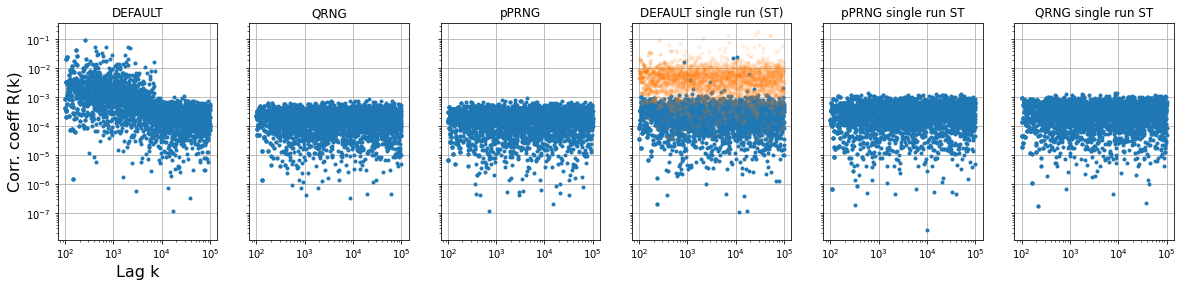

In [44]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(5*4, 4), sharex=True, sharey=True )

ax1.plot( xAxis, abs(defaultAutocorr), '.' )
ax1.set_title("DEFAULT")
ax2.plot( xAxis, abs(qrngAutocorr), '.' )
ax2.set_title("QRNG")
ax3.plot( xAxis, abs(pprngAutocorr), '.' )
ax3.set_title("pPRNG")

ax4.plot( xAxis, abs(defaultSeqAutocorr), '.' )
ax4.plot( xAxis, abs(defaultSeqSTAutocorr), '.', alpha=0.1 )
ax4.set_title("DEFAULT single run (ST)")

ax5.plot( xAxis, abs(prngSSTAutocorr), '.' )
ax5.set_title("pPRNG single run ST")

ax6.plot( xAxis, abs(qrngSSTAutocorr), '.' )
ax6.set_title("QRNG single run ST")

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_ylabel("Corr. coeff R(k)", fontsize=16)
ax1.set_xlabel("Lag k", fontsize=16)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

#fig.savefig("Autocorrelations_LargeLag_With60RepeatInPPRNGAndSingleRunPRNG_10000.png", dpi=150)

Observe that the correlation coefficients of QRNG and pPRNG are consistently $\sim 10^{-3}$, irrespective of whether the data was obtained in a parallel run (no sufix) or in a sequential run (single run, ST suffix).
**Note** That the correlation coefficients shown in the "DEFAULT single run (ST)" column were obtained from the data generated using the C++ `default_random_engine` PRNG, which on the author's systems defaults to the C++ `minstd_rand0` linear congruential generator, in a single run with $4$ threads (blue) or a single thread (orange).
The same PRNG was used to obtain the data for the "DEFAULT" figure, albeit across multiple code launches (thus multiple seeds) and running multiple threads.

We thus observe that using a linear congruential generator with a fairly short period of $m=2^{31}-1$ in a sequential simulation that is seeded exactly once will result in large correlations in the samples.
Using multiple seeds by either sampling in parallel, with each thread using a different RNG seed, or by collecting the data in multiple batches and each batch using a different seed will improve the correlation behaviour. 
This is due to the fact that the combined sequence of $N$ random numbers generated from a single fixed sequence by selection of $M$ random numbers in $K$ streams/threads with different starting points in the shared sequence will generally result in a sequence that differs from the one that would be obtained had we selected $N=MK$ random numbers sequentially from the same shared sequence.

### Clean-up

In [45]:
del defaultAutocorr
del qrngAutocorr
del pprngAutocorr
del defaultSeqAutocorr
del defaultSeqSTAutocorr
del prngSSTAutocorr
del qrngSSTAutocorr

In [46]:
gc.collect()

3894

## Statistical testing (without error propagation)

In this section a variety of statistical tests are performed on the data collected in the preceding sections of the notebook.

**The tests do not consider Gaussian error/uncertainty propagation which can be applied to mean-of-means analyses.**

### Tests assuming a Gaussian probability distribution

Next we assume that the observed $\tilde{\pi}_i$ are distributed according to a Normal probability distribution with a mean $\mu_0=\pi$ but an unknown variance $\sigma^2$.

In this case the appropriate test is the **Student's t-test** with $N-1$ degrees of freedom. The $T$-statistic is defined as

\begin{equation}
t := \frac{\langle \tilde{pi}\rangle_N - \mu_0}{s_N(\tilde{\pi})/\sqrt{N}} = \frac{\langle \tilde{pi}\rangle_N - \pi}{s_N(\tilde{\pi})/\sqrt{N}}
\end{equation}

where the empirical (non-biased) variance $s_N$ has been substituted for the unknown true standard deviation $\sigma$.

First we define the confidence parameter $\alpha$ and compute the $T$-statistic for both datasets

In [47]:
alpha = 0.05

In [48]:
print("Confidence interval corresponds to ", (1-alpha)*100, " % confidence")

Confidence interval corresponds to  95.0  % confidence


In [49]:
t_qrng = (np.average(qrng )  - np.pi )/ (np.std(qrng, ddof=1) / np.sqrt(len(qrng)))
t_prng = (np.average(prng )  - np.pi)/ (np.std(prng, ddof=1) / np.sqrt(len(prng)))

In [50]:
print("T-value of QRNG data: ", t_qrng)
print("T-value of PRNG data: ", t_prng)

T-value of QRNG data:  8.302747027874073
T-value of PRNG data:  10.363831255885355


In [51]:
tDOF = len(prngcase1_means) - 1
print("Number of degrees of freedom: ", tDOF)

Number of degrees of freedom:  29


Having obtained the $t$ values of the samples we next need to determine the acceptance range of $T \sim t_{N-1}$ for the significance level $\alpha$. These are the values $t_1, t_2$ s.t. $\mathbb{P}[T < t_1] = \frac{\alpha}{2}\quad \wedge\quad \mathbb{P}[T > t_2] = \frac{\alpha}{2}$, i.e., we are performing a two-sided test.

In [52]:
t_1 = stats.t.ppf(alpha/2, tDOF)
t_2 = stats.t.ppf(1-alpha/2, tDOF)

In [53]:
print("The acceptable range of T-values is [", t_1, " , ", t_2,"]")

print("The observed values are:")
print("T-value of QRNG data: ", t_qrng)
print("T-value of PRNG data: ", t_prng)

The acceptable range of T-values is [ -2.0452296421327034  ,  2.045229642132703 ]
The observed values are:
T-value of QRNG data:  8.302747027874073
T-value of PRNG data:  10.363831255885355


#### Conclusion

Both distributions fail the $T$-test _assuming_ both approximate $\pi$. The statistic of the QRNG being lower **implies a better approximation** when using QRNGs.

### T-Test for varying sample sizes

This part includes the "unwrapping" of the t-test as a visualisation.
The acceptance factors $t_1,t_2$ determined above for the entire dataset are repurposed, along with the average final empirical standard deviation to determine the acceptance
ranges at smaller sizes of the sample set. The evolution of the empirical mean is visualised with an overlay of the acceptance region.

In [54]:
t_1 = stats.t.ppf(alpha/2, tDOF)
t_2 = stats.t.ppf(1-alpha/2, tDOF)

Compute the standard deviation for the entirety of each dataset considered.

In [55]:
avgStd1k = np.std(qrngData1k['1000'].to_numpy(), ddof=1)

avgStdD = np.std(prngDataD[samplesOnUnitSquare].to_numpy(), ddof=1)

avgStd10k = np.std(qrngData['10000'].to_numpy(), ddof=1)
avgStd100k = np.std(qrngData[samplesOnUnitSquare].to_numpy(), ddof=1)

We first determine the fractions of the dataset we want to consider. Here specifically we look at fractions ranging from $1/2^4=1/16$ to $1$ sampled in logarithmic and linear fashion so as to smoothen the behaviour of the visualisation towards the larger sample sizes.

In [56]:
datasetFraction = np.logspace(-4, 0, 20)

In [57]:
linearDatasetFraction = np.linspace(1/10, 1, 10)

In [58]:
datasetFraction = np.unique( np.concatenate( [datasetFraction, linearDatasetFraction[:-2]]) )

In [59]:
sampleSetSizes = np.array([ int(N * subsetFraction) for subsetFraction in datasetFraction])

sampleSetSizes1k = np.array([ int(qrngData1k['1000'].to_numpy().shape[0] * subsetFraction) for subsetFraction in datasetFraction])
sampleSetSizesDs = np.array([ int(prngDataDs[samplesOnUnitSquare].to_numpy().shape[0] * subsetFraction) for subsetFraction in datasetFraction])

Print the sample sizes of the $\tilde{\pi}$ data that shall be considered.

In [60]:
sampleSetSizes

array([    1691,     2746,     4460,     7242,    11760,    19095,
          31007,    50349,    81755,   132753,   215561,   350023,
         568360,   922890,  1498567,  1691640,  2433339,  3383280,
        3951199,  5074920,  6415866,  6766560,  8458200, 10149840,
       10417934, 11841480, 13533120, 16916400])

Determine the lower and upper bounds of the $t$-test acceptance **assuming** that the empirical standard deviation of the entire dataset is a good approximation of the true standard deviation.

In [61]:
lowerBound1k = np.array([np.pi + t_1 * avgStd1k / np.sqrt(item) for item in sampleSetSizes1k])
upperBound1k = np.array([np.pi + t_2 * avgStd1k / np.sqrt(item) for item in sampleSetSizes1k])

lowerBoundD = np.array([np.pi + t_1 * avgStdD / np.sqrt(item) for item in sampleSetSizes1k])
upperBoundD = np.array([np.pi + t_2 * avgStdD / np.sqrt(item) for item in sampleSetSizes1k])

lowerBound10k = np.array([np.pi + t_1 * avgStd10k / np.sqrt(item) for item in sampleSetSizes])
upperBound10k = np.array([np.pi + t_2 * avgStd10k / np.sqrt(item) for item in sampleSetSizes])

lowerBound100k = np.array([np.pi + t_1 * avgStd100k / np.sqrt(item) for item in sampleSetSizes])
upperBound100k = np.array([np.pi + t_2 * avgStd100k / np.sqrt(item) for item in sampleSetSizes])

Compute the sample averages for each sample size and dataset.

In [62]:
qrngAverages1k = np.array([ np.average(qrngData1k['1000'].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])
prngAverages1k = np.array([ np.average(prngData1k['1000'].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])

prngAveragesD = np.array([ np.average(prngDataD[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])
prngAveragesDs = np.array([ np.average(prngDataDs[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizesDs])
prngAveragesDsst = np.array([ np.average(prngDataDsst[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizesDs])
qrngAveragesSST = np.array([ np.average(qrngDataSST[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizesDs])
prngAveragesSST = np.array([ np.average(prngDataSST[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizesDs])

qrngAverages10k = np.array([ np.average(qrngData['10000'].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])
prngAverages10k = np.array([ np.average(prngData['10000'].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])

qrngAverages100k = np.array([ np.average(qrngData[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])
prngAverages100k = np.array([ np.average(prngData[samplesOnUnitSquare].to_numpy()[:subsetSize]) for subsetSize in sampleSetSizes])

Additionally we create a set of ranges of samples that correspond to the number of batches ran.

In [63]:
piSamplesPerBatch = np.sum(Nrep)
batchSamples = np.array([piSamplesPerBatch * item for item in Nbatches])

In [64]:
assayBatchSamples = np.tile(batchSamples, NumAssays)

In [65]:
sampleRanges = np.zeros(assayBatchSamples.shape[0] + 1, dtype=int)
sampleRanges[1:] = np.cumsum(assayBatchSamples)

Next we select a cyclic colour map to represent each batch size

In [66]:
numColors = len(Nbatches)

In [67]:
cmap = mpl.cm.Set2

In [68]:
colors = [item for item in cmap.colors]

In [69]:
#remove the last colour
colors.pop(-1)

(0.7019607843137254, 0.7019607843137254, 0.7019607843137254)

We also add hatches to indicate which assay the data is from:

In [70]:
hatches = ['/', '+', '|', '-', '\\', 'x', 'o', 'O', '.', '*']

If we want to reverse the order of samples in the array while preserving the correspondence of coloring and hatching to batch size and assay number `colors` and `hatches` will have to be reversed, while `sampleRanges` will have to be recreated.

In [71]:
reverseDataView = False

if reverseDataView == True:
    colors.reverse()
    hatches.reverse()
    Nbatches.reverse()

    assayBatchSamples = np.tile(np.flip(batchSamples), NumAssays)
    sampleRanges = np.zeros(assayBatchSamples.shape[0] + 1, dtype=int)
    sampleRanges[1:] = np.cumsum(assayBatchSamples)

    qrngAverages10k = np.array([ np.average( qrngData['10000'].to_numpy()[-subsetSize:]) for subsetSize in sampleSetSizes])
    prngAverages10k = np.array([ np.average( prngData['10000'].to_numpy()[-subsetSize:]) for subsetSize in sampleSetSizes])
    
    qrngAverages100k = np.array([ np.average( qrngData[samplesOnUnitSquare].to_numpy()[-subsetSize:]) for subsetSize in sampleSetSizes])
    prngAverages100k = np.array([ np.average( prngData[samplesOnUnitSquare].to_numpy()[-subsetSize:]) for subsetSize in sampleSetSizes])

In [72]:
deviationPredictedMeanEmpiricalMean = (np.pi + np.pi* np.sqrt(np.pi/2 -1) * 0.8 / (int(samplesOnUnitSquare))) - np.average([qrngAverages100k[-1], qrngAverages100k[-1]]) 
print("The difference between predicted mean and empirical mean is: ", deviationPredictedMeanEmpiricalMean)

The difference between predicted mean and empirical mean is:  3.833062764524442e-06


------------

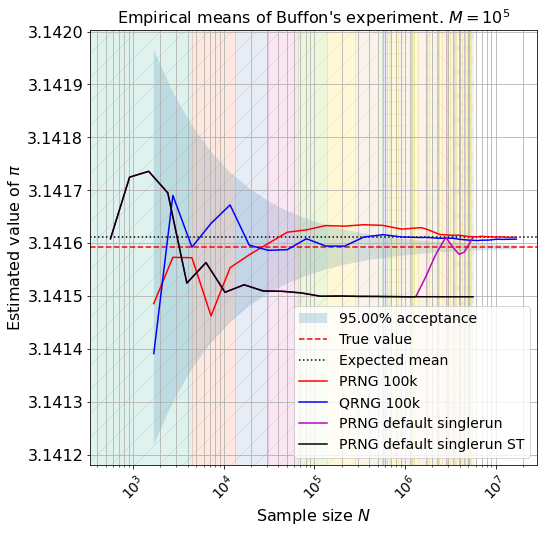

In [73]:
fig = plt.figure(figsize=(8,8))

ax = plt.gca()
ax.fill_between(sampleSetSizes, lowerBound100k, upperBound100k, label="{:.2f}% acceptance".format(100*(1-alpha)), alpha=0.2)

ax.axhline(np.pi, 0,1, color='r', linestyle='--', label="True value")
# Buffon boundary
ax.axhline(np.pi + np.pi* np.sqrt(np.pi/2 -1) * 0.8 / (int(samplesOnUnitSquare)), 0,1, color='k', linestyle=':', label="Expected mean")
# pi/4 boundary
ax.plot(sampleSetSizes, prngAverages100k, 'r-', label="PRNG 100k")
ax.plot(sampleSetSizes, qrngAverages100k, 'b-', label="QRNG 100k")

ax.plot(sampleSetSizesDs, prngAveragesDs, 'm-', label="PRNG default singlerun")
ax.plot(sampleSetSizesDs, prngAveragesDsst, 'k-', label="PRNG default singlerun ST")


#fill ranges
for idx in range(len(assayBatchSamples)):
    if idx < numColors:
        ax.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, hatch=hatches[0] )
    else:
        ax.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, hatch=hatches[idx // numColors])


ax.legend(loc='lower right', fontsize=14)
#ax.set_ylim((lowerBound.min(), upperBound.max()))
ax.set_xlabel("Sample size $N$", fontsize=16)
ax.set_ylabel("Estimated value of $\pi$", fontsize=16)

ax.set_title("Empirical means of Buffon's experiment. $M=10^5$", fontsize=16)

# overriddent by the `set_xscale` function
ax.set_xticks( sampleSetSizes )
ax.set_xticklabels( [str(item) for item in sampleSetSizes], fontsize=14, rotation=45)

# Add Pi to the y ticks and labels
ax.yaxis.set_tick_params(labelsize=16)
ax.grid(which='both')
ax.set_xscale('log', base=10)

fig.savefig("DSMCPI_ConvergenceOfMeanOfMeansAndAcceptanceRegion_{}_Buffon_BatchAndAssayIndexed.svg".format(samplesOnUnitSquare) )

"Expected mean" here refers to the predicted mean obtained by analysing the behaviour of the convergence of the means as function of the number of points-per-sample $M$.

Combined visualisation from the 3-workflows dataset for 10k and 100k pps

Text(0.5, 1.0, '100 000 pps')

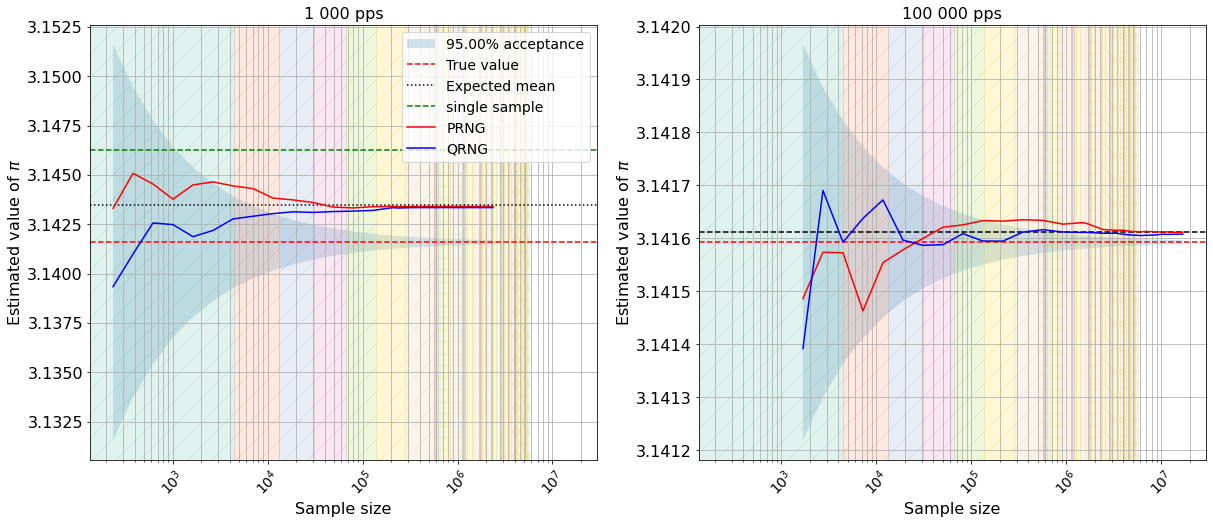

In [74]:
fig, (axl, axr) = plt.subplots(1, 2, sharex=True, figsize=(2*10, 8) )

#1k samples
#axl.fill_between(sampleSetSizes, lowerBound10k, upperBound10k, label="{:.2f}% acceptance".format(100*(1-alpha)), alpha=0.2)

#axl.axhline(np.pi, 0,1, color='r', linestyle='--', label="True value")
# Buffon boundary
#axl.axhline(np.pi + np.pi* np.sqrt(np.pi/2 -1) * 0.8 / (int('10000')), 0,1, color='k', linestyle='--', label="empiric mean")
# pi/4 boundary
#axl.plot(sampleSetSizes, prngAverages10k, 'r-', label="PRNG 10k")
#axl.plot(sampleSetSizes, qrngAverages10k, 'b-', label="QRNG 10k")

axl.fill_between(sampleSetSizes1k, lowerBound1k, upperBound1k, label="{:.2f}% acceptance".format(100*(1-alpha)), alpha=0.2)


axl.axhline(np.pi, 0,1, color='r', linestyle='--', label="True value")
# Buffon boundary
axl.axhline(np.pi + np.pi* np.sqrt(np.pi/2 -1) * 0.8 / (int('1000')), 0,1, color='k', linestyle=':', label="Expected mean")
axl.axhline(np.pi + np.pi* np.sqrt(np.pi/2 -1) * stats.norm.ppf(1-alpha/2)  / (1000), 0,1, color='g', linestyle='--', label="single sample")
# pi/4 boundary
axl.plot(sampleSetSizes1k, prngAverages1k, 'r-', label="PRNG")
axl.plot(sampleSetSizes1k, qrngAverages1k, 'b-', label="QRNG")


#fill ranges
for idx in range(len(assayBatchSamples)):
    if idx < numColors:
        axl.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, hatch=hatches[0] )
    else:
        axl.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, hatch=hatches[idx // numColors])


axl.legend(loc='upper right', fontsize=14)

axl.set_xlabel("Sample size", fontsize=16)
axl.set_ylabel("Estimated value of $\pi$", fontsize=16)

# overriddent by the `set_xscale` function
axl.set_xticks( sampleSetSizes )
axl.set_xticklabels( [str(item) for item in sampleSetSizes], fontsize=14, rotation=45)

axl.yaxis.set_tick_params(labelsize=16)
axl.grid(which='both')


#100k samples
axr.fill_between(sampleSetSizes, lowerBound100k, upperBound100k, label="{:.2f}% acceptance".format(100*(1-alpha)), alpha=0.2)


axr.axhline(np.pi, 0,1, color='r', linestyle='--', label="True value")
# Buffon boundary
axr.axhline(np.pi + np.pi* np.sqrt(np.pi/2 -1) * 0.8 / (int(samplesOnUnitSquare)), 0,1, color='k', linestyle='--', label="empiric mean")
# pi/4 boundary
axr.plot(sampleSetSizes, prngAverages100k, 'r-', label="PRNG")
axr.plot(sampleSetSizes, qrngAverages100k, 'b-', label="QRNG")

#fill ranges
for idx in range(len(assayBatchSamples)):
    if idx < numColors:
        axr.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, hatch=hatches[0] )#label="Batch size {:d}".format(Nbatches[idx % numColors]), hatch=hatches[0])
    else:
        axr.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, hatch=hatches[idx // numColors])


axr.set_xlabel("Sample size", fontsize=16)
axr.set_ylabel("Estimated value of $\pi$", fontsize=16)

axr.set_xticks( sampleSetSizes )
axr.set_xticklabels( [str(item) for item in sampleSetSizes], fontsize=14, rotation=45)
axr.yaxis.set_tick_params(labelsize=16)
axr.grid(which='both')
axl.set_xscale('log', base=10)

#plot titles
axl.set_title("1 000 pps", fontsize=16)
axr.set_title("100 000 pps", fontsize=16)

#-------------

#fig.savefig("DSMCPI_ConvergenceOfMeanOfMeansAndAcceptanceRegion_10kVs100k_Buffon_BatchAndAssayIndexed.svg")

-----------------

### Visualising the empirical mean scaled by the variance

Next we consider a common visualisation of a "relative approximation error":
$$ \frac{|\mathbb{E}[X_N] - \pi|}{\sqrt{Var[X_N]}} $$

which indicates how large - in units of the standard deviation of the data - the mean is from the true value.

Determine the cumulative mean and cumulative standard deviation for each dataset.

In [75]:
prngCumulativeSum10k = prngData['10000'].expanding().mean().to_numpy()
qrngCumulativeSum10k = qrngData['10000'].expanding().mean().to_numpy()
prngCumulativeSumD = prngDataD[samplesOnUnitSquare].expanding().mean().to_numpy()
prngCumulativeSumDs = prngDataDs[samplesOnUnitSquare].expanding().mean().to_numpy()
prngCumulativeSumDsst = prngDataDsst[samplesOnUnitSquare].expanding().mean().to_numpy()
prngCumulativeSumSST = prngDataSST[samplesOnUnitSquare].expanding().mean().to_numpy()
qrngCumulativeSumSST = qrngDataSST[samplesOnUnitSquare].expanding().mean().to_numpy()

qrngStds10k = qrngData['10000'].expanding().std().to_numpy()
prngStds10k = prngData['10000'].expanding().std().to_numpy()
prngStdsD = prngDataD[samplesOnUnitSquare].expanding().std().to_numpy()
prngStdsDs = prngDataDs[samplesOnUnitSquare].expanding().std().to_numpy()
prngStdsDsst = prngDataDsst[samplesOnUnitSquare].expanding().std().to_numpy()
prngStdsSST = prngDataSST[samplesOnUnitSquare].expanding().std().to_numpy()
qrngStdsSST = qrngDataSST[samplesOnUnitSquare].expanding().std().to_numpy()

In [76]:
prngCumulativeSum100k = prngData[samplesOnUnitSquare].expanding().mean().to_numpy()
qrngCumulativeSum100k = qrngData[samplesOnUnitSquare].expanding().mean().to_numpy()

qrngStds100k = qrngData[samplesOnUnitSquare].expanding().std().to_numpy()
prngStds100k = prngData[samplesOnUnitSquare].expanding().std().to_numpy()

In [77]:
#verify that we have the correct number of sample points
prngData['10000'].shape == prngCumulativeSum10k.shape

True

In [78]:
prngNormalisedDeviation10k = abs(prngCumulativeSum10k - np.pi)/prngStds10k

In [79]:
qrngNormalisedDeviation10k = abs(qrngCumulativeSum10k - np.pi)/qrngStds10k

In [80]:
prngDeviation10k = abs(prngCumulativeSum10k - np.pi)
qrngDeviation10k = abs(qrngCumulativeSum10k - np.pi)

prngDeviation100k = abs(prngCumulativeSum100k - np.pi)
qrngDeviation100k = abs(qrngCumulativeSum100k - np.pi)

In [81]:
prngNormalisedDeviation100k = abs(prngCumulativeSum100k - np.pi)/prngStds100k
qrngNormalisedDeviation100k = abs(qrngCumulativeSum100k - np.pi)/qrngStds100k

prngNormalisedDeviationD = abs(prngCumulativeSumD - np.pi)/prngStdsD
prngNormalisedDeviationDs = abs(prngCumulativeSumDs - np.pi)/prngStdsDs
prngNormalisedDeviationDsst = abs(prngCumulativeSumDsst - np.pi)/prngStdsDsst
prngNormalisedDeviationSST = abs(prngCumulativeSumSST - np.pi)/prngStdsSST
qrngNormalisedDeviationSST = abs(qrngCumulativeSumSST - np.pi)/qrngStdsSST

Subsample the data to reduce plot time and memory consumption plotting the entire dataset as is would result in an overly dense, illegible, plot whose creation will require substantial RAM resources.

In [82]:
stepSize = 10 # select every 10th sample size value

In [83]:
prngCumulativeSum100k.shape[0]

16916400

In [84]:
sampleSizes = np.arange(1, prngCumulativeSum100k.shape[0], stepSize)

In [85]:
sampleSizes.shape

(1691640,)

Determine the sample sizes after which the errors leave the acceptable range provided by the t-Test to not return.

In [86]:
b=np.array( [max(abs(t_1), abs(t_2))/np.sqrt(item) for item in sampleSizes] )

In [87]:
exceedErrorBoundIdxArray = np.argwhere( prngNormalisedDeviation100k[::stepSize] > b ).flatten()

In [88]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [89]:
prngFirstExceedIndex = consecutive(exceedErrorBoundIdxArray)[-1][0]

In [90]:
exceedErrorBoundIdxArrayQRNG = np.argwhere( qrngNormalisedDeviation100k[::stepSize] > b ).flatten()
qrngFirstExceedIndex = consecutive(exceedErrorBoundIdxArrayQRNG)[-1][0]

In [91]:
print("PRNGs exceed the t-test boundary for sample sets larger than: ", sampleSizes[prngFirstExceedIndex])
print("QRNGs exceed the t-test boundary for sample sets larger than: ", sampleSizes[qrngFirstExceedIndex])

PRNGs exceed the t-test boundary for sample sets larger than:  230821
QRNGs exceed the t-test boundary for sample sets larger than:  1047021


How much larger is the sample size accepted with QRNGs than with PRNGs?

In [92]:
sampleSizes[qrngFirstExceedIndex]/sampleSizes[prngFirstExceedIndex]

4.5360734075322435

----

**Conclusion**: 
Both datasets ultimately result in statistically significantly different results from the true value $\pi$ (c.f. plots in the preceding section). But when a QRNG is used to obtain the samples the range of sample sizes of $\tilde{\pi}$ that result in _no statistically significant deviations of the mean from the true value of_ $\pi$ is $\sim 4.54\times$ larger than if a (parallel) PRNG is used.

----

Next we determine the sample size at which the QRNG error falls below the final PRNG error (approximation error for the entire PRNG dataset).

In [93]:
terminalErrorValuePRNG = prngNormalisedDeviation100k[-1]

In [94]:
qrngErrorLowerThanPRNGfinalError_indices = np.argwhere( qrngNormalisedDeviation100k[::stepSize] < terminalErrorValuePRNG ).flatten()

In [95]:
qrngFirstLowerErrorIndex = consecutive(qrngErrorLowerThanPRNGfinalError_indices)[-1][0]

In [96]:
print("The normalised deviation from pi using QRNGs is smaller than the final value attained using PRNGs for samples larger than: ", sampleSizes[qrngFirstLowerErrorIndex])

The normalised deviation from pi using QRNGs is smaller than the final value attained using PRNGs for samples larger than:  1915871


How much larger is the entire dataset than the subset for which the normalised deviation of the QRNG dataset remains below that of the entire PRNG dataset?

In [97]:
sampleSizes[-1] / sampleSizes[qrngFirstLowerErrorIndex]

8.829608569679273

In [98]:
sampleSizes[-1]

16916391

In [99]:
sampleSizes[qrngFirstLowerErrorIndex]

1915871

----

**Conclusion**:
This shows that the normalised deviation of the approximation utilising $1.69\cdot 10^{7}$ samples obtained with a (parallel) PRNG is larger than the same utilising $\geq 1.92\cdot 10^{6}$ samples obtained with a QRNG. Thus when using a QRNG to obtain $\pi$ estimates we observe that the normalised deviation (relative approximation error) is consistently smaller than the PRNG error for dataset sizes starting at $1.92\cdot 10^{6}$ samples.

In a direct comparison we could thus reduce the dataset size of the QRNG by a factor of $\sim 8.83\times$ and still obtain a smaller relative error than were we to use a pPRNG.

----

Next we visualise the normalised deviations, absolute errors and the behaviour of the standard deviation for datasets obtained with various RNGs.

In [100]:
sampleSizesD = np.arange(1, prngNormalisedDeviationD.shape[0], stepSize)

sampleSizesDs = np.arange(1, prngNormalisedDeviationDs.shape[0], stepSize)

Plot the t-test visualisation

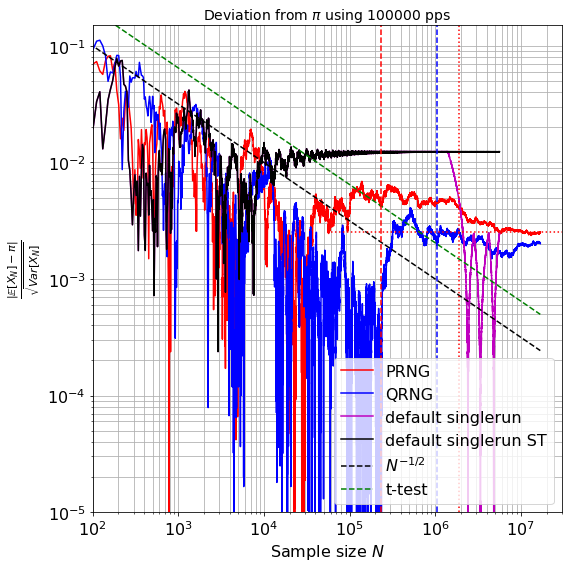

In [101]:
fig = plt.figure(figsize=(8,8))

ax = fig.gca()

ax.plot(sampleSizes,prngNormalisedDeviation100k[::stepSize], 'r-', label="PRNG")
ax.plot(sampleSizes,qrngNormalisedDeviation100k[::stepSize],  'b-', label="QRNG")
ax.plot(sampleSizesDs, prngNormalisedDeviationDs[::stepSize],  'm-', label="default singlerun")
ax.plot(sampleSizesDs, prngNormalisedDeviationDsst[::stepSize],  'k-', label="default singlerun ST")


ax.plot(sampleSizes, [1/np.sqrt(item) for item in sampleSizes],  'k--', label="$N^{-1/2}$")

ax.axhline(prngNormalisedDeviation100k[-1], xmin=0.5, xmax=1, color='r', linestyle=':')

ax.plot( sampleSizes, [max(abs(t_1), abs(t_2))/np.sqrt(item) for item in sampleSizes], color='g', linestyle='--', label="t-test")

#indicate after what sample size QRNGs consistently yield better results
ax.axvline(sampleSizes[qrngFirstLowerErrorIndex], color='r', linestyle=':')

#indicate sample sizes for which PRNG and QRNG permanently leave the expected 1/sqrt(N) scaling
ax.axvline(sampleSizes[prngFirstExceedIndex], color='r', linestyle='--')
ax.axvline(sampleSizes[qrngFirstExceedIndex], color='b', linestyle='--')

ax.legend(loc='lower right', fontsize=16)

ax.set_xlabel("Sample size $N$", fontsize=16)

ax.set_ylabel("$\\frac{|\mathbb{E}[X_N] - \pi|}{\sqrt{Var[X_N]}}$" ,fontsize=16)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

ax.grid(which='both')
ax.set_xscale('log', base=10)
ax.set_xlim((100, 3e7))
ax.set_ylim((1e-5,1.5e-1))


ax.set_yscale('log', base=10)
ax.set_title("Deviation from $\pi$ using {} pps".format(samplesOnUnitSquare), fontsize=14)
fig.tight_layout()

fig.savefig(
            "DSMCPI_StandardizedDeviationFromPi_3RNGs{}.png".format(samplesOnUnitSquare) \
)

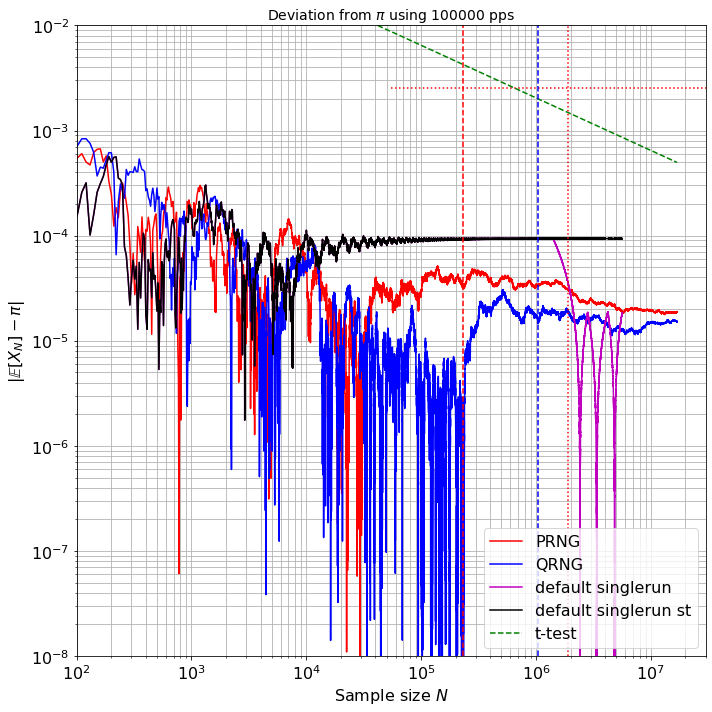

In [102]:
fig = plt.figure(figsize=(10,10))

ax = fig.gca()

ax.plot(sampleSizes,abs(prngCumulativeSum100k - np.pi)[::stepSize], 'r-', label="PRNG")
ax.plot(sampleSizes,abs(qrngCumulativeSum100k - np.pi)[::stepSize],  'b-', label="QRNG")
ax.plot(sampleSizesDs, abs(prngCumulativeSumDs - np.pi)[::stepSize],  'm-', label="default singlerun")
ax.plot(sampleSizesDs, abs(prngCumulativeSumDsst - np.pi)[::stepSize],  'k-', label="default singlerun st")


ax.axhline(prngNormalisedDeviation100k[-1], xmin=0.5, xmax=1, color='r', linestyle=':')

ax.plot( sampleSizes, [max(abs(t_1), abs(t_2))/np.sqrt(item) for item in sampleSizes], color='g', linestyle='--', label="t-test")

#indicate after what sample size QRNGs consistently yield better results
ax.axvline(sampleSizes[qrngFirstLowerErrorIndex], color='r', linestyle=':')

#indicate sample sizes for which PRNG and QRNG permanently leave the expected 1/sqrt(N) scaling
ax.axvline(sampleSizes[prngFirstExceedIndex], color='r', linestyle='--')
ax.axvline(sampleSizes[qrngFirstExceedIndex], color='b', linestyle='--')

ax.legend(loc='lower right', fontsize=16)

ax.set_xlabel("Sample size $N$", fontsize=16)

ax.set_ylabel("$|\mathbb{E}[X_N] - \pi|$" ,fontsize=16)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

ax.grid(which='both')
ax.set_xscale('log', base=10)
ax.set_xlim((100, 3e7))
ax.set_ylim((1e-8,1e-2))


ax.set_yscale('log', base=10)
ax.set_title("Deviation from $\pi$ using {} pps".format(samplesOnUnitSquare), fontsize=14)
fig.tight_layout()

fig.savefig("DSMCPI_AbsDeviationFromPi_{}.png".format(samplesOnUnitSquare) )

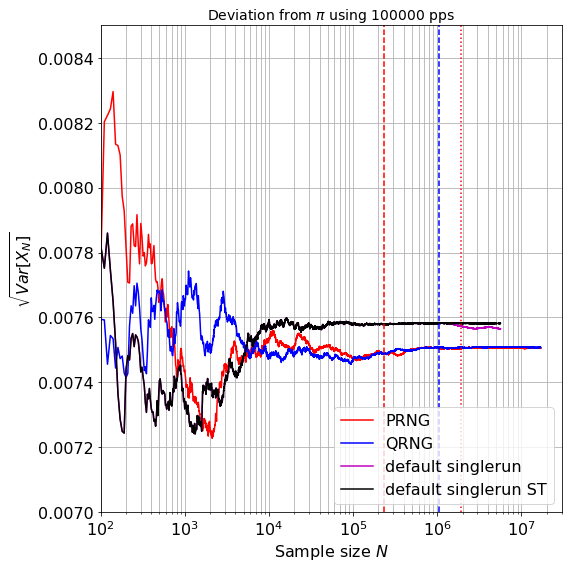

In [103]:
fig = plt.figure(figsize=(8,8))

ax = fig.gca()

ax.plot(sampleSizes,prngStds100k[::stepSize], 'r-', label="PRNG")
ax.plot(sampleSizes,qrngStds100k[::stepSize],  'b-', label="QRNG")
ax.plot(sampleSizesDs,prngStdsDs[::stepSize],  'm-', label="default singlerun")
ax.plot(sampleSizesDs,prngStdsDsst[::stepSize],  'k-', label="default singlerun ST")

ax.axhline(prngNormalisedDeviation100k[-1], xmin=0.5, xmax=1, color='r', linestyle=':')

#indicate after what sample size QRNGs consistently yield better results
ax.axvline(sampleSizes[qrngFirstLowerErrorIndex], color='r', linestyle=':')

#indicate sample sizes for which PRNG and QRNG permanently leave the expected 1/sqrt(N) scaling
ax.axvline(sampleSizes[prngFirstExceedIndex], color='r', linestyle='--')
ax.axvline(sampleSizes[qrngFirstExceedIndex], color='b', linestyle='--')

ax.legend(loc='lower right', fontsize=16)

ax.set_xlabel("Sample size $N$", fontsize=16)

ax.set_ylabel("$\sqrt{Var[X_N]}$" ,fontsize=16)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

ax.grid(which='both')
ax.set_xscale('log', base=10)
ax.set_xlim((100, 3e7))
ax.set_ylim((0.007,0.0085))


ax.set_title("Deviation from $\pi$ using {} pps".format(samplesOnUnitSquare), fontsize=14)
fig.tight_layout()

fig.savefig("DSMCPI_StandardDeviationEvolution_{}.png".format(samplesOnUnitSquare) )

Consideringthe deviations below the t-test threshold to be acceptable we are also interested in the quotient of the approximation errors just before the values exceed the limits for the last time.

In [104]:
prngNormalisedDeviation100k[prngFirstExceedIndex-1]/qrngNormalisedDeviation100k[qrngFirstExceedIndex-1]

1.1158803933895087

In [105]:
qrngNormalisedDeviation100k[qrngFirstExceedIndex-1]/prngNormalisedDeviation100k[prngFirstExceedIndex-1]

0.8961533923563978

----

Next visualise the behaviour in comparison to $\sim N^{-1/2}$.

**Rationale:**
The t-test boundary used previously assumes the knowledge of the true standard deviation and uses the empirical standard deviation for a very large dataset as a proxy. This makes it unsuitable as a criterion to determine the sample size required to achieve a given normalised deviation (approximation error). Here the common $1/\sqrt{N}$ scaling is generally used and the difference between the thresholds obtained with the simple rule and the t-test corresponds to a constant factor.

Hence we consider the evolution of the normalised deviation vs. the sample size and determine the largest sample size for which the deviation exceeds the threshold for good.

In [106]:
b=np.array( [1/np.sqrt(item) for item in sampleSizes] )

In [107]:
exceedErrorBoundIdxArrayPRNG = np.argwhere( prngNormalisedDeviation100k[::stepSize] > b ).flatten()

In [108]:
prngFirstExceedIndex = consecutive(exceedErrorBoundIdxArrayPRNG)[-1][0]

In [109]:
exceedErrorBoundIdxArrayQRNG = np.argwhere( qrngNormalisedDeviation100k[::stepSize] > b ).flatten()
qrngFirstExceedIndex = consecutive(exceedErrorBoundIdxArrayQRNG)[-1][0]

In [110]:
print("PRNGs exceed the N^{-1/2} boundary for sample sets larger than: ", sampleSizes[prngFirstExceedIndex])
print("QRNGs exceed the N^{-1/2} boundary for sample sets larger than: ", sampleSizes[qrngFirstExceedIndex])

PRNGs exceed the N^{-1/2} boundary for sample sets larger than:  96201
QRNGs exceed the N^{-1/2} boundary for sample sets larger than:  305051


How much larger is the QRNG thershold than the PRNG one?

In [111]:
sampleSizes[qrngFirstExceedIndex]/sampleSizes[prngFirstExceedIndex]

3.170975353686552

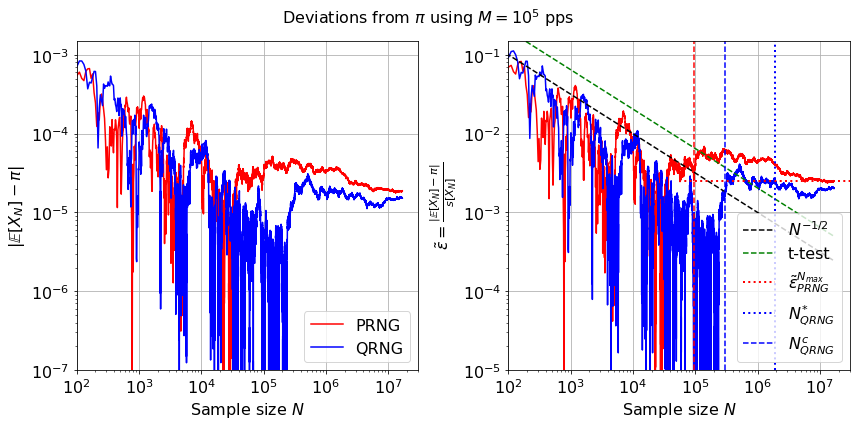

In [112]:
fig, (axl, ax) = plt.subplots(1,2, figsize=(2*6,6), sharex=True)


axl.plot(sampleSizes,prngDeviation100k[::stepSize], 'r-', label="PRNG")
axl.plot(sampleSizes,qrngDeviation100k[::stepSize],  'b-', label="QRNG")

ax.plot(sampleSizes,prngNormalisedDeviation100k[::stepSize], 'r-',)
ax.plot(sampleSizes,qrngNormalisedDeviation100k[::stepSize],  'b-',)
ax.plot(sampleSizes, [1/np.sqrt(item) for item in sampleSizes],  'k--', label="$N^{-1/2}$")
ax.plot( sampleSizes, [max(abs(t_1), abs(t_2))/np.sqrt(item) for item in sampleSizes], color='g', linestyle='--', label="t-test")

ax.axhline(prngNormalisedDeviation100k[-1], xmin=0.5, xmax=1, color='r', linestyle=':', linewidth=2, label="$\\tilde{\epsilon}_{PRNG}^{N_{max}}$")
#indicate after what sample size QRNGs consistently yield better results
ax.axvline(sampleSizes[qrngFirstLowerErrorIndex], color='b', linestyle=':', linewidth=2, label="$N_{QRNG}^{*}$")
#indicate sample sizes for which PRNG and QRNG permanently leave the expected 1/sqrt(N) scaling
ax.axvline(sampleSizes[prngFirstExceedIndex], color='r', linestyle='--')
ax.axvline(sampleSizes[qrngFirstExceedIndex], color='b', linestyle='--', label="$N_{QRNG}^{c}$")

ax.legend(loc='lower right', fontsize=16)
axl.legend(loc='lower right', fontsize=16)

#labels
ax.set_xlabel("Sample size $N$", fontsize=16)
axl.set_xlabel("Sample size $N$", fontsize=16)

ax.set_ylabel("$\\tilde{\epsilon} = \\frac{|\mathbb{E}[X_N] - \pi|}{s[X_N]}$" ,fontsize=16)
axl.set_ylabel("$|\mathbb{E}[X_N] - \pi|$" ,fontsize=16)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

axl.yaxis.set_tick_params(labelsize=16)
axl.xaxis.set_tick_params(labelsize=16)

ax.grid(which='major')
axl.grid(which='major')
ax.set_xscale('log', base=10)
ax.set_xlim((100, 3e7))
ax.set_ylim((1e-5,1.5e-1))

axl.set_ylim((1e-7,1.5e-3))

ax.set_yscale('log', base=10)
axl.set_yscale('log', base=10)

fig.suptitle("Deviations from $\pi$ using $M=10^5$ pps", fontsize=16)
fig.tight_layout()

#fig.savefig("DSMCPI_DeviationFromPi_{}.svg".format(samplesOnUnitSquare) )

**According to this metric QRNG maintain a persistent lead in the quality of approximation compared to PRNG beyond ~10 000 samples.**

We may utilise a $\sim3.17\times$ more samples when using a QRNG than when using a pPRNG.

Consideringthe deviations below the $\sim N^{-1/2}$ limit to be acceptable we are interested in the quotient of the approximation errors just before the values exceed the limits for the last time.

In [113]:
prngNormalisedDeviation100k[prngFirstExceedIndex-1]/qrngNormalisedDeviation100k[qrngFirstExceedIndex-1]

7.314512301145986

In [114]:
qrngNormalisedDeviation100k[qrngFirstExceedIndex-1]/prngNormalisedDeviation100k[prngFirstExceedIndex-1]

0.13671451476584803

**Conclusion**: The approximation error achievable with a pPRNG is $\approx 7.31\times$ larger than the same with a QRNG due to the latter maintaining the $1/\sqrt{N}$ convergence behaviour for larger sample sizes. 

Additionally we consider the quotient of the pPRNG normalised deivation and the QRNG normalised deviation for the entire dataset, i.e., in the case when both appear to have converged to a stationary value:

In [115]:
prngNormalisedDeviation100k[-1]/qrngNormalisedDeviation100k[-1]

1.2482412414069564

In [116]:
qrngNormalisedDeviation100k[-1]/prngNormalisedDeviation100k[-1]

0.801127191465689

**Conclusion**: The approximation error of the Buffon approximation method attainable with the pPRNG is $\approx 1.25\times$ larger than that of the QRNG (conversely the latter is only $\approx 80\%$ of the former).

### Roundoff error analysis

**ATTENTION** The calculations in this section will result in a long runtime, even when parallelised. As such it is advised to skip this section unless the results are of particular interest!

Given the extraordinary amount of data used here and the reliance on sums as well as differences (i.e., numerically potentially unstable operations) we have to check whether results may be skewed due to numerical rounding errors. To this end operations relying on summation (average, std-deviation) are modified to utilise the stable [Kahan summation function](https://en.wikipedia.org/wiki/Kahan_summation_algorithm).

**Note**: Pythons `math` module provides an implementation of stable summation in its `fsum` function. Unfortunately parallelisation of the calculation using Numba's `njit` is apparently not possible when using this function, hence the implementation of the Kahan-Neumaier summation here.

In [117]:
@nb.njit
def KahanBabushkaNeumaierSum(data:np.array):
    '''
    Implementation of stable summation of an array of floating point
    numbers.
    '''
    #Make the use of double precision values explicit
    Sum = np.float64(0.0)
    Compensation = np.float64(0.0)

    for i in range(data.shape[0]):
        val = np.float64(data[i])
        t = Sum + val
        if abs(Sum) >= abs(val):
            Compensation += (Sum - t) + val
        else:
            Compensation += (val - t) + Sum
        Sum = t
    
    return Sum + Compensation

In [118]:
@nb.njit
def stableAverage(data:np.array):
    '''
    Calculation of the mean of an array using stable summation.
    '''
    return KahanBabushkaNeumaierSum(data) / data.shape[0]

In [119]:
@nb.njit
def stableStdDev(data:np.array):
    '''
    Calculation of the standard deviation of an array utilising
    stable summation and averaging.
    '''
    mean = stableAverage(data)
    delta = data - mean
    var = KahanBabushkaNeumaierSum( delta**2 )/ (data.shape[0] - 1)
    return np.sqrt(var)

Compare the results obtained using simple averaging and stable averaging.

In [120]:
stableSampleAvg = stableAverage( prngDataD[samplesOnUnitSquare].to_numpy() )

In [121]:
simpleSampleAvg = prngDataD[samplesOnUnitSquare].to_numpy().mean()

In [122]:
print("Difference between stable and simple averages: ", stableSampleAvg - simpleSampleAvg)

Difference between stable and simple averages:  -1.7763568394002505e-15


Note that machine precision for `double` in [C/C++](https://en.cppreference.com/w/cpp/types/climits) is $\approx 2.22\cdot 10^{-16}$ or by the [IEEE 754p standard](https://de.wikipedia.org/wiki/IEEE_754#Zahlenformate_und_andere_Festlegungen_des_IEEE-754-Standards) $1.1\cdot 10^{-16}$.

Given the **10 orders of magnitude** difference between the acceptable (according to the $1/\sqrt{N}$ scaling) absolute approximation error and the observed difference between simple and stable averages we can safely neglect rounding errors as a potential source of errors in this analysis!

The following computes the cumulative averages for $1/4$ of the dataset size to verify this conclusion.

In [123]:
prngCumulativeAvgD_stable = prngDataD[samplesOnUnitSquare][:prngDataD.shape[0]//4].expanding().apply(stableAverage, engine="numba", raw=True, engine_kwargs={"parallel": True} )

In [124]:
prngCumulativeAvgD_unstable = prngDataD[samplesOnUnitSquare][:prngDataD.shape[0]//4].expanding().mean()

In [125]:
diffOfMeans = prngCumulativeAvgD_unstable.to_numpy() - prngCumulativeAvgD_stable.to_numpy()
relErr = diffOfMeans / prngCumulativeAvgD_stable

print("Minimal difference of the means: ", min(diffOfMeans))
print("Maximum difference of the means: ", max(diffOfMeans))
print("Minimal relative difference: ", min(relErr))
print("Maximal relative difference: ", max(relErr))

Minimal difference of the means:  0.0
Maximum difference of the means:  0.0
Minimal relative difference:  0.0
Maximal relative difference:  0.0


**Conclusion**: There is no observable difference between a simple and stable average calculation given $1/4$ of the dataset. We can hence safely neglect rounding errors as a potential distortion of our observations.

### Autocorrelations of the means

**ATTENTION** The calculations in this section may result in a long runtime, even when parallelised. As such it is advised to skip this section unless the results are of particular interest!
Additionally this section will result in large memory utilisation, which may crash the Python kernel!

In [126]:
k = np.logspace(0, 6.5, 3000, dtype=int)

In [127]:
prngDSSTAutocorr = biasedACFlarge( prngCumulativeSumDsst ,  k)
prngDSSTAutocorr = prngDSSTAutocorr[0]

prngDSAutocorr = biasedACFlarge( prngCumulativeSumDs ,  k)
prngDSAutocorr = prngDSAutocorr[0]

prngAutocorr = biasedACFlarge( prngCumulativeSum100k ,  k)
prngAutocorr = prngAutocorr[0]

qrngAutocorr = biasedACFlarge( qrngCumulativeSum100k ,  k)
qrngAutocorr = qrngAutocorr[0]

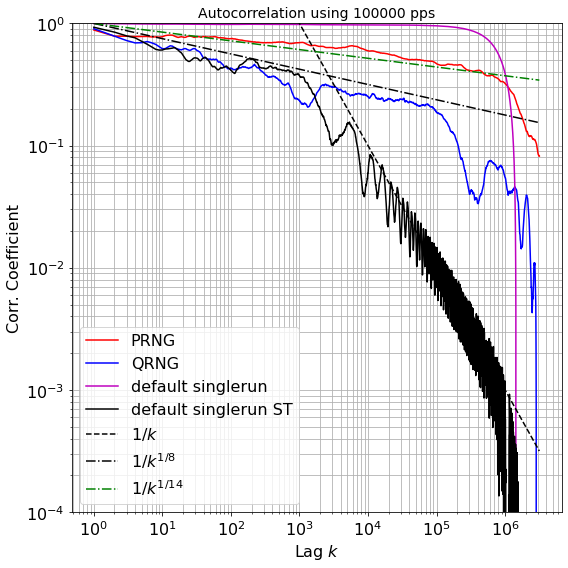

In [128]:
fig = plt.figure(figsize=(8,8))

ax = fig.gca()

ax.plot(k, prngAutocorr, color='r', linestyle=None, label="PRNG")
ax.plot(k, qrngAutocorr,  color='b', linestyle=None, label="QRNG")

ax.plot(k, prngDSAutocorr,  color='m', linestyle=None, label="default singlerun")

ax.plot(k, prngDSSTAutocorr,  color='k', linestyle=None, label="default singlerun ST")



ax.plot(k, 1e3/k,  color="black", linestyle='--', label="$1/k$")
ax.plot(k, 1/(k**(1/8)),  color="black", linestyle='-.', label="$1/k^{1/8}$")
ax.plot(k, 1/(k**(1/14)),  color="green", linestyle='-.', label="$1/k^{1/14}$")

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel("Lag $k$", fontsize=16)

ax.set_ylabel("Corr. Coefficient" ,fontsize=16)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

ax.grid(which='both')

ax.set_ylim( (1e-4, 1) )
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.set_title("Autocorrelation using {} pps".format(samplesOnUnitSquare), fontsize=14)
fig.tight_layout()

fig.savefig(
            "DSMCPI_AutocorrOfMeans_3RNGs{}.png".format(samplesOnUnitSquare) \
)

### Frequency analysis

Given the observations in the previous section we now apply a Fourier transformation to the **abs. deviation** to determine whether and which frequencies/periods exist in the cumulative average.

In [129]:
prngFT = np.fft.fft( abs(prngCumulativeSum100k[:prngCumulativeSumDsst.shape[0]] - np.pi) )

prngFTDsst = np.fft.fft( abs(prngCumulativeSumDsst -np.pi) )
prngFTDs = np.fft.fft( abs(prngCumulativeSumDs - np.pi) )
qrngFTSST = np.fft.fft( abs(qrngCumulativeSumSST - np.pi) )
#prngFTSST = np.fft.fft( abs(prngCumulativeSumSST - np.pi) )
prngFTD = np.fft.fft( abs(prngCumulativeSumD[:prngCumulativeSumDsst.shape[0]] - np.pi) )

In [130]:
frequencies = np.fft.fftfreq(prngCumulativeSumDsst.shape[0])

In [131]:
2*int(samplesOnUnitSquare)/(2**31-1)

9.313225750491594e-05

/tmp/ipykernel_17077/4220555204.py:14: RuntimeWarning: divide by zero encountered in divide
  ax.plot(frequencies[:prngFT.shape[0]//2], 1e-3/(frequencies[:prngFT.shape[0]//2]),  color="black", linestyle='-.', label="$\sim 1/f$")


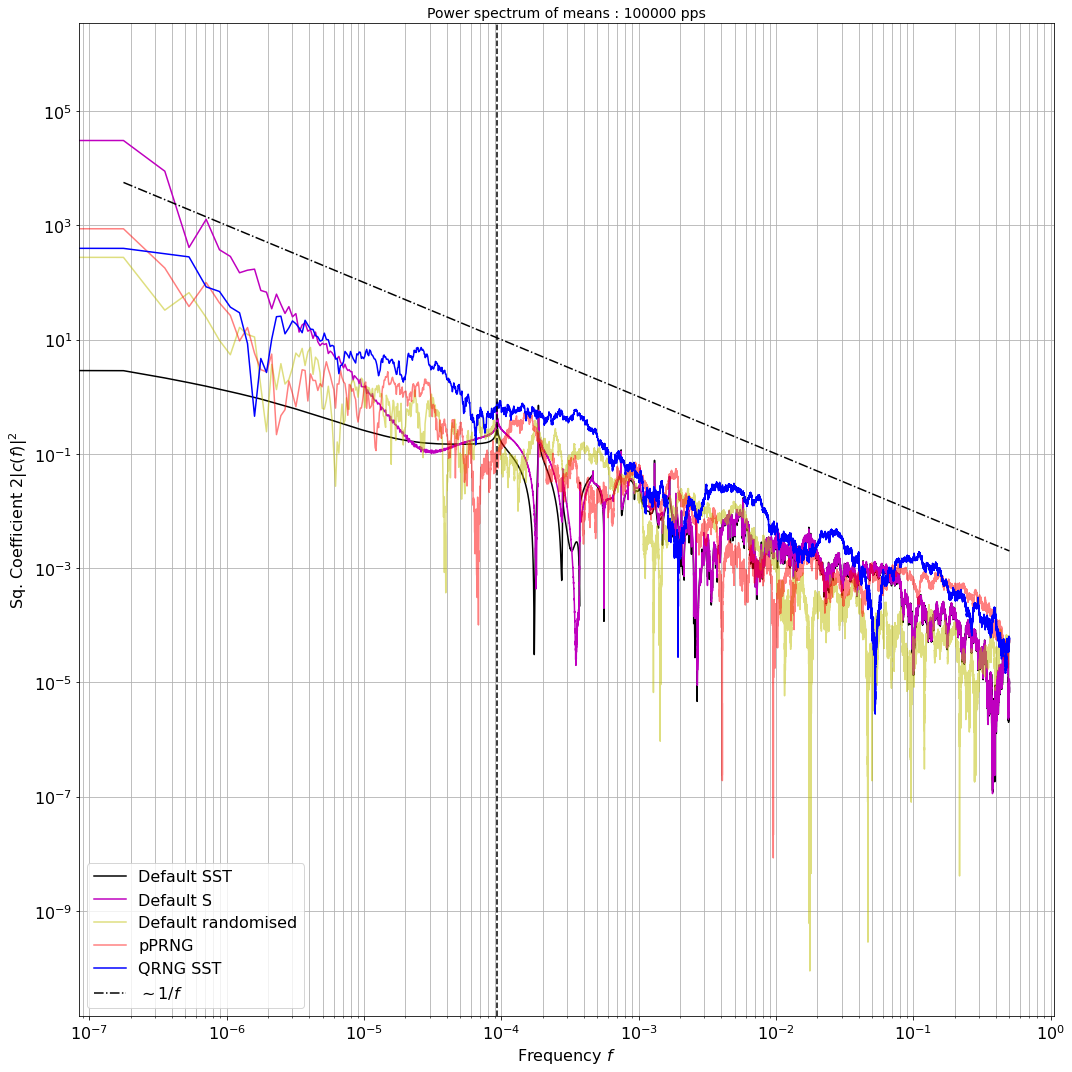

In [132]:
fig = plt.figure(figsize=(15,15))

ax = fig.gca()

# frequencies
ax.plot(frequencies[:prngFTDsst.shape[0]//2], 2*abs(prngFTDsst[:prngFTDsst.shape[0]//2])**2, color="black", linestyle="-", ms=2, label="Default SST")
ax.plot(frequencies[:prngFTDs.shape[0]//2], 2*abs(prngFTDs[:prngFTDs.shape[0]//2])**2, color="m", linestyle="-", ms=2, label="Default S")
ax.plot(frequencies[:prngFTD.shape[0]//2], 2*abs(prngFTD[:prngFTD.shape[0]//2])**2, color="y", linestyle="-", ms=2, alpha=0.5, label="Default randomised")

ax.plot(frequencies[:prngFT.shape[0]//2], 2*abs(prngFT[:prngFT.shape[0]//2])**2, color="red", linestyle="-", ms=2, alpha=0.5, label="pPRNG")
ax.plot(frequencies[:qrngFTSST.shape[0]//2], 2*abs(qrngFTSST[:qrngFTSST.shape[0]//2])**2, color="blue", linestyle="-", ms=2, label="QRNG SST")

# Decay behaviour
ax.plot(frequencies[:prngFT.shape[0]//2], 1e-3/(frequencies[:prngFT.shape[0]//2]),  color="black", linestyle='-.', label="$\sim 1/f$")

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel("Frequency $f$", fontsize=16)

ax.set_ylabel("Sq. Coefficient $2|c(f)|^2$" ,fontsize=16)

ax.axvline( 2*int(samplesOnUnitSquare)/(2**31-1) , color='k', linestyle='--')

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

ax.grid(which='both')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.set_title("Power spectrum of means : {} pps".format(samplesOnUnitSquare), fontsize=14)
fig.tight_layout()

fig.savefig(
            "DSMCPI_PowerSpectrumOfMeans_{}.png".format(samplesOnUnitSquare) \
)

The dashed vertical line indicates the location of a very notable peak present in the spectrum of the single-run (single seed) single-threaded data collected using the C++ `default_random_engine` PRNG. The exact value of the frequency is $f = 2M/m$, where $M$ is the number of points-per-sample used for $\tilde{\pi}$ and $m$ is the period of the linear congruential engine. In the given case $f = 200000/(2^{31}-1)\approx 9.3\cdot 10^{-5}$.

We thus observe notable peaks at low frequencies when using the `minstd_rand0` linear congruential generator either in a sequential setting, or a thread-parallel setting with a limited number (here: 4) of different RNG seeds. If the samples are collected using the same LCG but across multiple runs (batches) of the simulation utilising multiple threads the additional entropy introduced by the seed-variation shifts and broadens the stark peaks at lower frequencies, but does not eliminate them fully. I.e., additional randomness introduced through the random choice of the seeds results in an improvement of the simple LCG.

This holds true for the parellel PRNGs, too, but neither them nor the QRNG display any notable frequency peaks and thus any notable periodic structures in the data.

#### Clean-up of the FFT data

In [133]:
del prngFT

del prngFTDsst
del prngFTDs
del qrngFTSST
del prngFTD

In [134]:
del prngDSSTAutocorr
del prngDSAutocorr
del prngAutocorr
del qrngAutocorr

In [135]:
gc.collect()

49430

### Assay-based averages

According to the above plot the empirical means appear to converge to within the "systematic" uncertainty bound in the span of a single assay, with further assays bringing no notable benefits.

As such we may revert back to considering all assays as an ensemble, which permits us to obtain at least 10 averages from one workflow run.

In [136]:
qrngDataByAssay = np.vstack( np.split(qrng, NumAssays * NumWorkflows) )
prngDataByAssay = np.vstack( np.split(prng, NumAssays * NumWorkflows) )

In [137]:
datasetFractionByAssay = np.logspace(-3, 0, 10)

In [138]:
datasetFractionByAssay

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

In [139]:
assaySampleSetSizes = np.array([ int(qrngDataByAssay.shape[1] * subsetFraction) for subsetFraction in datasetFractionByAssay])

In [140]:
print(assaySampleSetSizes)

[   563   1214   2617   5638  12148  26172  56388 121484 261729 563880]


In [141]:
qrngAssayAverages = np.vstack([ np.average(qrngDataByAssay[:, :subsetSize], axis=1) for subsetSize in assaySampleSetSizes])
prngAssayAverages = np.vstack([ np.average(prngDataByAssay[:, :subsetSize], axis=1) for subsetSize in assaySampleSetSizes])

In [142]:
alphaMin = 0.1
alphaMax = 1.0
dAlpha = (alphaMax - alphaMin) / NumAssays

In [143]:
#adapting acceptance ranges and plot boundaries
tDOF = len(prngcase1_means) - 1

t_1 = stats.t.ppf(0.01/2, tDOF)
t_2 = stats.t.ppf(1-0.01/2, tDOF)


sysErrorBound = np.pi* np.sqrt(np.pi/2 -1) *stats.norm.ppf(1-alpha/2)  / (int(samplesOnUnitSquare))

lowerBound = np.array([np.pi + t_1 * avgStd100k / np.sqrt(item) for item in assaySampleSetSizes])
upperBound = np.array([np.pi + t_2 * avgStd100k / np.sqrt(item) for item in assaySampleSetSizes])

In [144]:
lowerBound

array([3.14072054, 3.14099875, 3.14118815, 3.14131706, 3.14140491,
       3.14146474, 3.14150551, 3.14153328, 3.14155221, 3.1415651 ])

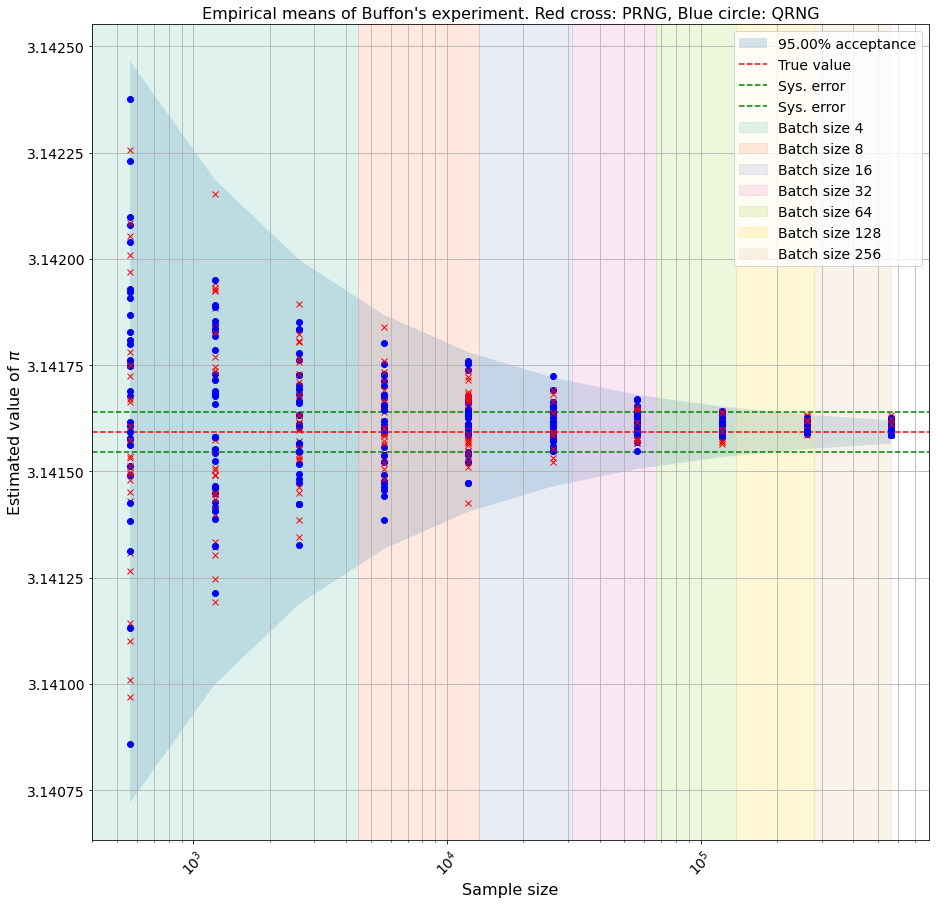

In [145]:
fig = plt.figure(figsize=(15,15))

ax = plt.gca()
ax.fill_between(assaySampleSetSizes, lowerBound, upperBound, label="{:.2f}% acceptance".format(100*(1-alpha)), alpha=0.2)


ax.axhline(np.pi, 0,1, color='r', linestyle='--', label="True value")
# Buffon boundary
ax.axhline(np.pi + sysErrorBound, 0,1, color='g', linestyle='--', label="Sys. error")
ax.axhline(np.pi - sysErrorBound, 0,1, color='g', linestyle='--', label="Sys. error")

# plot the curves, with varying alpha values
for curveIdx in range(NumAssays * NumWorkflows):
    ax.plot(assaySampleSetSizes, qrngAssayAverages[:, curveIdx] , 'bo')
    ax.plot(assaySampleSetSizes, prngAssayAverages[:, curveIdx] , 'rx')
#fill ranges
for idx in range(len(assayBatchSamples)):
    if idx < numColors:
        ax.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, label="Batch size {:d}".format(Nbatches[idx % numColors]))

ax.legend(loc='upper right', fontsize=14)

ax.set_xlabel("Sample size", fontsize=16)
ax.set_ylabel("Estimated value of $\pi$", fontsize=16)

ax.set_title("Empirical means of Buffon's experiment. Red cross: PRNG, Blue circle: QRNG", fontsize=16)


ax.set_xticks( sampleSetSizes )
ax.set_xticklabels( [str(item) for item in sampleSetSizes], fontsize=14, rotation=45)
#ax.set_yticklabels( [item for item in ax.get_yticklabels()], fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.grid(which='both')
ax.set_xscale('log', base=10)

#fig.savefig("DSMCPI_ConvergenceOfAssayMeansAndAcceptanceRegion_{}_Buffon.png".format(samplesOnUnitSquare) )

#### Split-assay averages

From the total plot and assay-based plot above we can deduce that the means converge to within the "systematic" error boundary (dictated by the number of points on $[0,1/2]\times[0,\pi/2]$) within the batch sizes 4-64. Since the total number of samples in an assay is split roughly evenly between batch size 256 and the rest we may partition each assay additionally into two equal parts, to double the number of means available.

In [146]:
qrngDataBySubAssay = np.vstack( np.split(qrng, NumAssays * NumWorkflows * 2) )
prngDataBySubAssay = np.vstack( np.split(prng, NumAssays * NumWorkflows * 2) )

For better comparison with the visualisations above we re-use the sample sizes, restricting ourselves only to ranges that are within half-size of the assay.

In [147]:
assaySampleSetSizes[:-3]

array([  563,  1214,  2617,  5638, 12148, 26172, 56388])

In [148]:
qrngSubAssayAverages = np.vstack([ np.average(qrngDataBySubAssay[:, :subsetSize], axis=1) for subsetSize in assaySampleSetSizes[:-3]])
prngSubAssayAverages = np.vstack([ np.average(prngDataBySubAssay[:, :subsetSize], axis=1) for subsetSize in assaySampleSetSizes[:-3]])

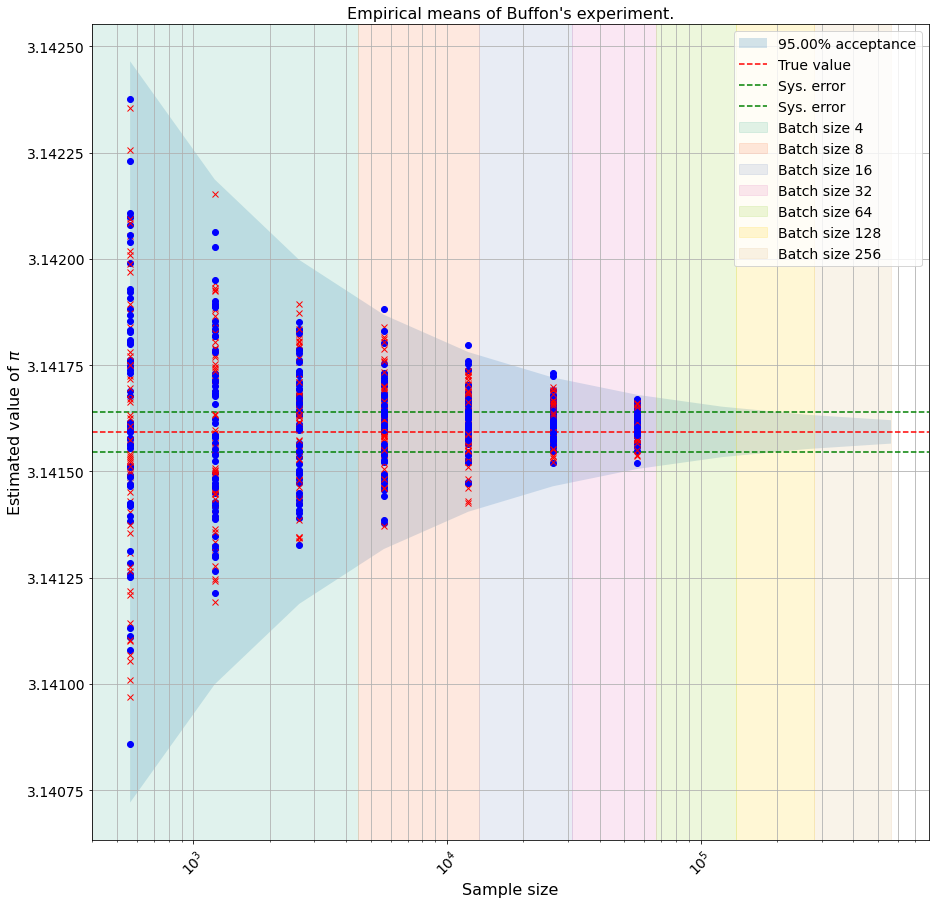

In [149]:
fig = plt.figure(figsize=(15,15))

ax = plt.gca()
ax.fill_between(assaySampleSetSizes, lowerBound, upperBound, label="{:.2f}% acceptance".format(100*(1-alpha)), alpha=0.2)


ax.axhline(np.pi, 0,1, color='r', linestyle='--', label="True value")
# Buffon boundary
ax.axhline(np.pi + sysErrorBound, 0,1, color='g', linestyle='--', label="Sys. error")
ax.axhline(np.pi - sysErrorBound, 0,1, color='g', linestyle='--', label="Sys. error")

# plot the curves, with varying alpha values
for curveIdx in range(NumAssays * NumWorkflows * 2):
    ax.plot(assaySampleSetSizes[:-3], prngSubAssayAverages[:, curveIdx], 'rx')#, alpha=alphaMin + curveIdx*dAlpha)
    ax.plot(assaySampleSetSizes[:-3], qrngSubAssayAverages[:, curveIdx], 'bo')#, alpha=alphaMin + curveIdx*dAlpha)

#fill ranges
for idx in range(len(assayBatchSamples)):
    if idx < numColors:
        ax.axvspan(sampleRanges[idx], sampleRanges[idx+1], color=colors[idx % numColors], alpha=0.2, label="Batch size {:d}".format(Nbatches[idx % numColors]))


ax.legend(loc='upper right', fontsize=14)
#ax.set_ylim((lowerBound.min(), upperBound.max()))
ax.set_xlabel("Sample size", fontsize=16)
ax.set_ylabel("Estimated value of $\pi$", fontsize=16)

ax.set_title("Empirical means of Buffon's experiment.", fontsize=16)
#ax.set_xlim((Q_min - 1.5*(2*subsetSize//2 - Q_min), Q_max + 1.5*(-2*subsetSize//2 + Q_max)))

ax.set_xticks( sampleSetSizes )
ax.set_xticklabels( [str(item) for item in sampleSetSizes], fontsize=14, rotation=45)
#ax.set_yticklabels( [item for item in ax.get_yticklabels()], fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.grid(which='both')
ax.set_xscale('log', base=10)

#fig.savefig("DSMCPI_ConvergenceOfSubAssayMeansAndAcceptanceRegion_{}_Buffon.png".format(samplesOnUnitSquare) )

## Fitting distributions

In [150]:
import lmfit

In [151]:
qrngSubset = qrngSubAssayAverages[-1] #case1_means 
prngSubset = prngSubAssayAverages[-1] #prngcase1_means

In [152]:
histValuesPRNG, binCentresPRNG, binEdgesPRNG, histErrorbarsPRNG = normhist(prngSubset)
histValuesQRNG, binCentresQRNG, binEdgesQRNG, histErrorbarsQRNG = normhist(qrngSubset)

In [153]:
assert np.all( histValuesPRNG > 0) == True, "Empty bins!"

In [154]:
assert np.all( histValuesQRNG > 0) == True, "Empty bins!"

Text(0.5, 1.0, 'Total means: 60')

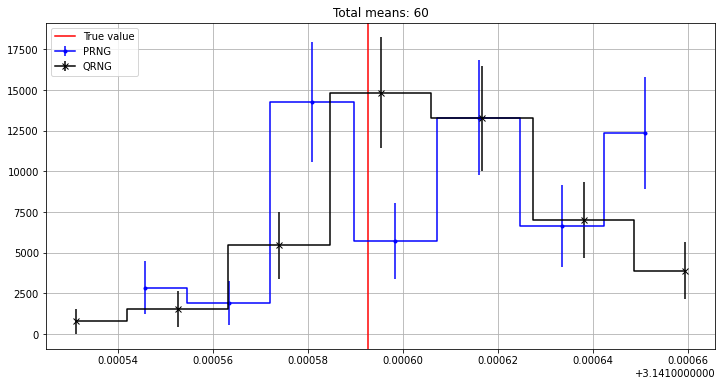

In [155]:
# compute the histograms

fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
ax.errorbar(binCentresPRNG, histValuesPRNG, yerr=histErrorbarsPRNG, marker='.', color='b', drawstyle='steps-mid', label="PRNG")
ax.errorbar(binCentresQRNG, histValuesQRNG, yerr=histErrorbarsQRNG, marker='x', color='k', drawstyle='steps-mid', label="QRNG")

ax.axvline(np.pi, color='r', label="True value")
ax.legend( loc='upper left')
ax.grid(which='major')
ax.set_title("Total means: {:d}".format(len(prngSubset)) )
#ax.set_yscale('log')

Joint plot of the histograms for all selected sample sizes of the sub-assay

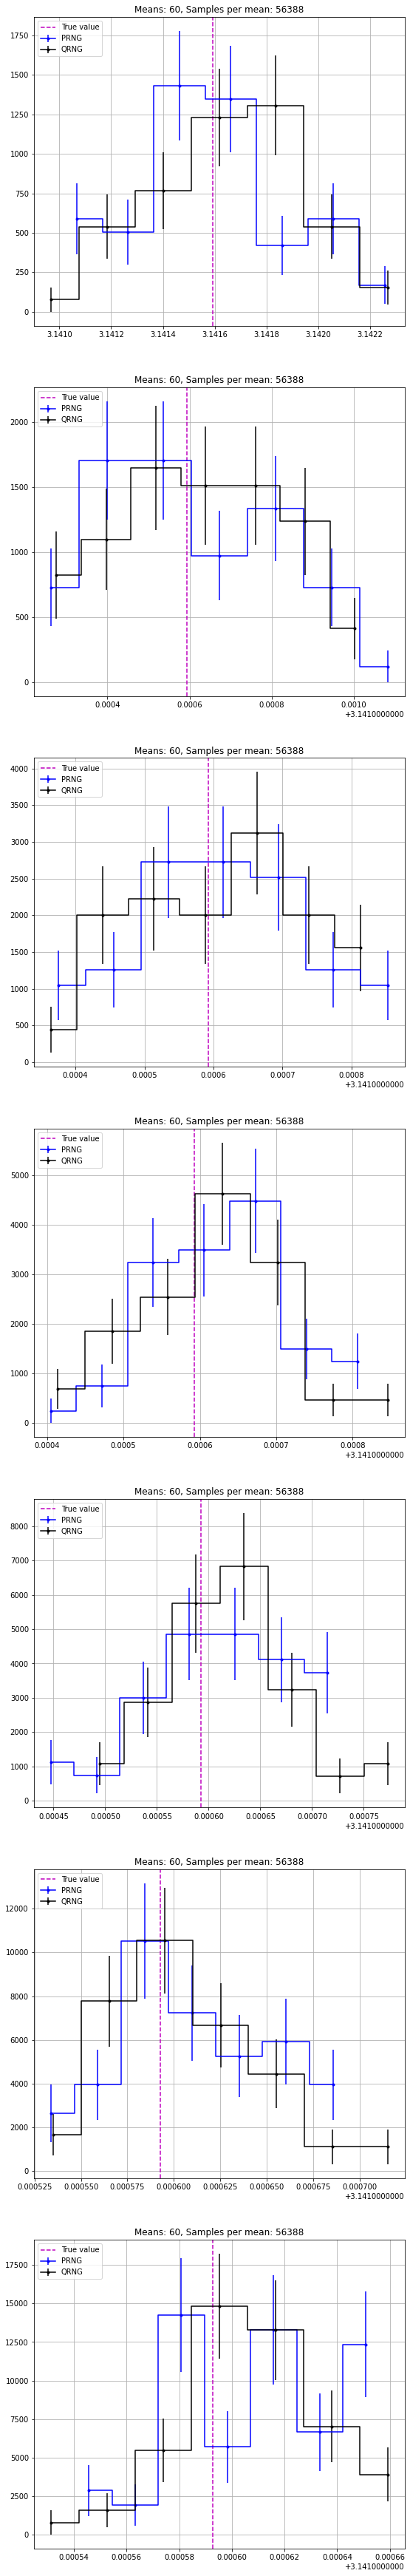

In [156]:
NumPlots = len(assaySampleSetSizes[:-3])

fig, axArray = plt.subplots( NumPlots, 1, figsize=(9, NumPlots*9), sharex=False, sharey=False )

#1st row - PRNG constrained fit and "histogram" vs. best fits
for idx in range(NumPlots):
    histValuesPRNG, binCentresPRNG, binEdgesPRNG, histErrorbarsPRNG = normhist(prngSubAssayAverages[idx])
    histValuesQRNG, binCentresQRNG, binEdgesQRNG, histErrorbarsQRNG = normhist(qrngSubAssayAverages[idx])
    # dist fitting
    axArray[idx].errorbar(binCentresPRNG, histValuesPRNG, yerr=histErrorbarsPRNG, marker='.', color='b', drawstyle='steps-mid', label="PRNG")
    axArray[idx].errorbar(binCentresQRNG, histValuesQRNG, yerr=histErrorbarsQRNG, marker='.', color='k', drawstyle='steps-mid', label="QRNG")

#add the true value indicator
for i in range(NumPlots):
    axArray[i].axvline(np.pi, color='m', linestyle='--', label="True value")
    axArray[i].legend(loc='upper left')
    axArray[i].grid(which='major')
    axArray[i].set_title("Means: {:d}, Samples per mean: {:d}".format(len(prngSubset),assaySampleSetSizes[idx] ) )
    

fig.savefig("Histograms_SubAssaySampling_SamplesOnUnitSquare_{}_Buffon.png".format(samplesOnUnitSquare), dpi=150)

### Fitting distributions

In the following we attempt to perform a test for statistical significance assuming the samples are drawn from a normal distribution and employing the likelihood-based hypothesis tests.

We _assume_ that the data follows a normal distribution $\mathcal{N}(\mu, \sigma)$ with $\mu=\pi$ and an unknown $\sigma$. Since the normalisation of the histogram does not transform it into a probability density we add an amplitude parameter $\alpha$ to compensate.

In [157]:
def modelNormalDistribution(x, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp( -1/2 * (x - np.pi)**2/sigma**2)

In [158]:
normalModel = lmfit.Model(modelNormalDistribution)

In [159]:
normalModelParam = normalModel.make_params(sigma=np.std(qrngSubset) )

Fit the model to the data for PRNGs and QRNGs. **NOTE**: For the Buffon's needle example the binning had to be performed separately for PRNG and QRNG results since attempting to bin QRNG data into PRNG bins resulted in empty bins

In [160]:
resultPRNG = normalModel.fit( data=histValuesPRNG, params=normalModelParam, x=binCentresPRNG, weights=1./(histErrorbarsPRNG))

In [161]:
resultQRNG = normalModel.fit( data=histValuesQRNG, params=normalModelParam, x=binCentresQRNG, weights=1./(histErrorbarsQRNG))

In [162]:
lmfit.report_fit( resultPRNG )

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 7
    # variables        = 1
    chi-square         = 24.0041073
    reduced chi-square = 4.00068455
    Akaike info crit   = 10.6262036
    Bayesian info crit = 10.5721138
    R-squared          = -0.47940067
[[Variables]]
    sigma:  7.3517e-05 +/- 3.0504e-05 (41.49%) (init = 2.932926e-05)


In [163]:
lmfit.report_fit( resultQRNG )

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 7
    # variables        = 1
    chi-square         = 24.5583840
    reduced chi-square = 4.09306400
    Akaike info crit   = 10.7860021
    Bayesian info crit = 10.7319122
    R-squared          = 0.51660688
[[Variables]]
    sigma:  2.5593e-05 +/- 5.0758e-06 (19.83%) (init = 2.932926e-05)


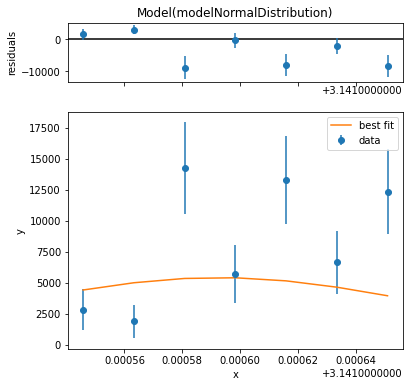

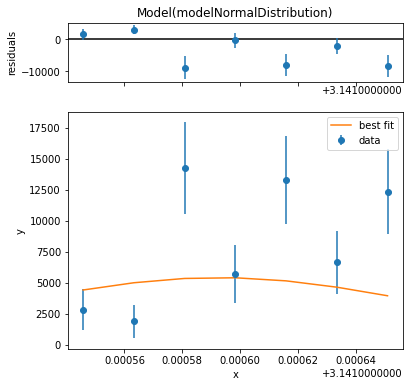

In [164]:
resultPRNG.plot()

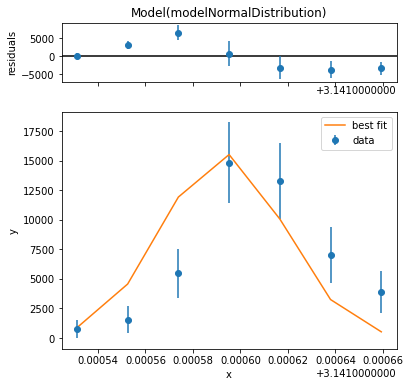

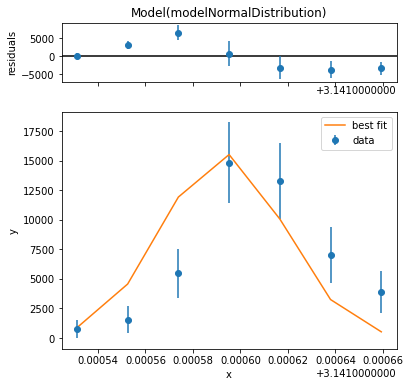

In [165]:
resultQRNG.plot()

The fit to PRNG data is useless, whereas the fit to QRNG data produces reasonable estimates - underpinning the superior quality of the QRNG data.

In the above it was assumed that $\mu=\pi$ and a 2-parameter exponential was fit to the data. Next we relinquish the assumption to determine best fit values and test whether the obtained best fit values are statistically significantly different to the model values obtained under the previously stated assumption. I.e., we compare the obtained fit to the best fit and check whether the latter is significantly better.

In [166]:
def modelFreeNormalDistribution(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( -1/2 * (x-mu)**2/sigma**2)

In [167]:
normalFreeModel = lmfit.Model(modelFreeNormalDistribution)

In [168]:
normalFreeModelParam = normalFreeModel.make_params(mu=np.pi, sigma=np.std(qrngSubset))

In [169]:
resultBestFitPRNG = normalFreeModel.fit( data=histValuesPRNG, params=normalFreeModelParam, x=binCentresPRNG, weights=1./(histErrorbarsPRNG))
resultBestFitQRNG = normalFreeModel.fit( data=histValuesQRNG, params=normalFreeModelParam, x=binCentresQRNG, weights=1./(histErrorbarsQRNG))

In [170]:
lmfit.report_fit( resultBestFitPRNG )

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 7
    # variables        = 2
    chi-square         = 12.1435919
    reduced chi-square = 2.42871839
    Akaike info crit   = 7.85624029
    Bayesian info crit = 7.74806059
    R-squared          = 0.16458957
[[Variables]]
    mu:     3.14162627 +/- 1.6630e-05 (0.00%) (init = 3.141593)
    sigma:  4.2762e-05 +/- 1.0841e-05 (25.35%) (init = 2.932926e-05)


In [171]:
lmfit.report_fit( resultBestFitQRNG )

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 7
    # variables        = 2
    chi-square         = 1.85353887
    reduced chi-square = 0.37070777
    Akaike info crit   = -5.30169404
    Bayesian info crit = -5.40987374
    R-squared          = 0.93934660
[[Variables]]
    mu:     3.14161003 +/- 2.9340e-06 (0.00%) (init = 3.141593)
    sigma:  2.8398e-05 +/- 2.1132e-06 (7.44%) (init = 2.932926e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, sigma) = -0.2624


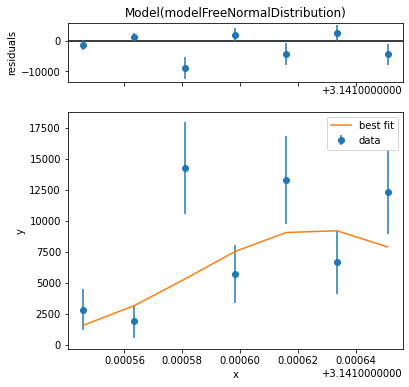

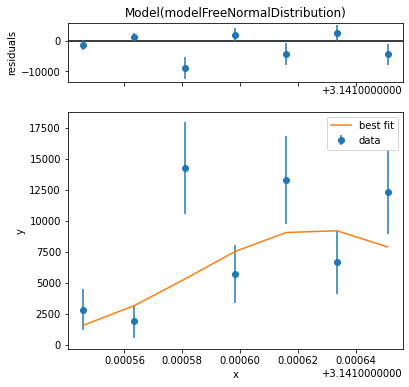

In [172]:
resultBestFitPRNG.plot()

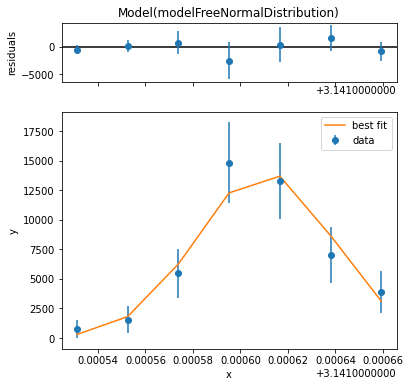

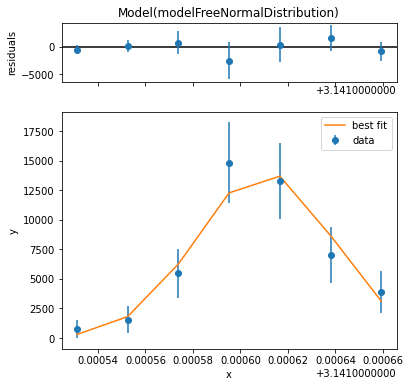

In [173]:
resultBestFitQRNG.plot()

#### Visualisation of the fitted distributions

In [174]:
visSigmaRange = 3*max(resultBestFitQRNG.best_values['sigma'], resultBestFitPRNG.best_values['sigma'],  resultPRNG.best_values['sigma'],  resultQRNG.best_values['sigma'])
xValues = np.linspace( np.pi - visSigmaRange, np.pi + visSigmaRange, 1000)

In [175]:
constrainedPRNGdistribution = modelNormalDistribution( xValues,  resultPRNG.best_values['sigma'])
constrainedQRNGdistribution = modelNormalDistribution( xValues,  resultQRNG.best_values['sigma'])

bestFitPRNGdistribution = modelFreeNormalDistribution( xValues, resultBestFitPRNG.best_values['mu'], resultBestFitPRNG.best_values['sigma'])
bestFitQRNGdistribution = modelFreeNormalDistribution( xValues, resultBestFitQRNG.best_values['mu'], resultBestFitQRNG.best_values['sigma'])

The plots below are arranged in a $2\times 2$ grid, with rows representing constrained distributions and columns representing best fit.

[Text(3.141813205229267, 0, '3.14181'),
 Text(3.1417396880161093, 0, '3.14174'),
 Text(3.141666170802951, 0, '3.14167'),
 Text(3.141592653589793, 0, '3.14159'),
 Text(3.141519136376635, 0, '3.14152'),
 Text(3.141445619163477, 0, '3.14145'),
 Text(3.1413721019503194, 0, '3.14137')]

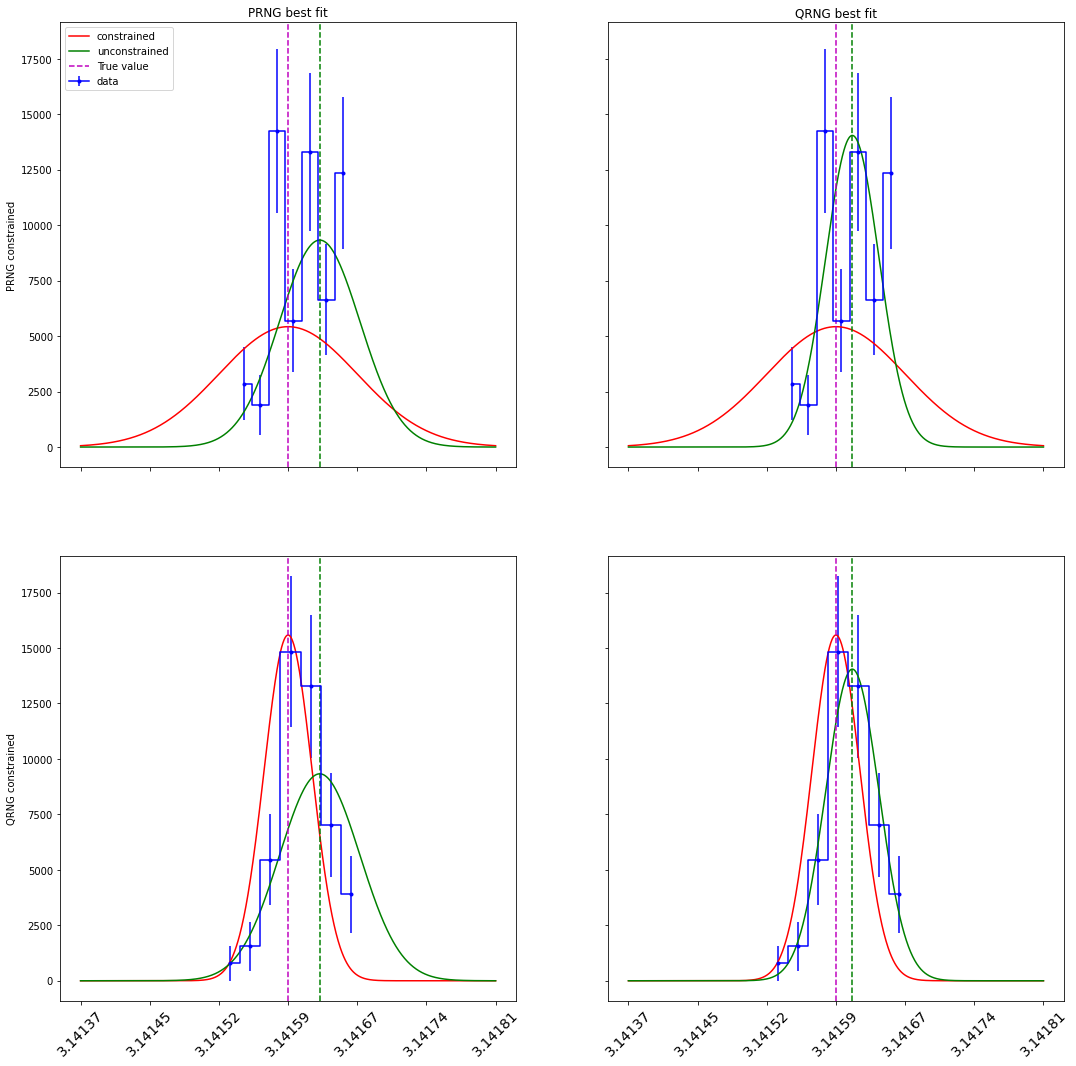

In [176]:
fig, axArray = plt.subplots( 2, 2, figsize=(2*9, 2*9), sharex=True, sharey=True )

#1st row - PRNG constrained fit and "histogram" vs. best fits
axArray[0, 0].errorbar(binCentresPRNG, histValuesPRNG, yerr=histErrorbarsPRNG, marker='.', color='b', drawstyle='steps-mid', label="data")
axArray[0, 1].errorbar(binCentresPRNG, histValuesPRNG, yerr=histErrorbarsPRNG, marker='.', color='b', drawstyle='steps-mid', label="data")

axArray[0, 0].plot(xValues, constrainedPRNGdistribution, color='r', label="constrained")
axArray[0, 0].plot(xValues, bestFitPRNGdistribution, color='g', label="unconstrained")
axArray[0, 0].axvline(resultBestFitPRNG.best_values['mu'], color='g', linestyle='--')

axArray[0, 1].plot(xValues, constrainedPRNGdistribution, color='r', label="constrained")
axArray[0, 1].plot(xValues, bestFitQRNGdistribution, color='g', label="unconstrained")
axArray[0, 1].axvline(resultBestFitQRNG.best_values['mu'], color='g', linestyle='--')

#2nd row - QRNG constrained fit and histogram vs. best fits

axArray[1, 0].errorbar(binCentresQRNG, histValuesQRNG, yerr=histErrorbarsQRNG, marker='.', color='b', drawstyle='steps-mid', label="data")
axArray[1, 1].errorbar(binCentresQRNG, histValuesQRNG, yerr=histErrorbarsQRNG, marker='.', color='b', drawstyle='steps-mid', label="data")

axArray[1, 0].plot(xValues, constrainedQRNGdistribution, color='r', label="constrained")
axArray[1, 0].plot(xValues, bestFitPRNGdistribution, color='g', label="unconstrained")
axArray[1, 0].axvline(resultBestFitPRNG.best_values['mu'], color='g', linestyle='--')

axArray[1, 1].plot(xValues, constrainedQRNGdistribution, color='r', label="constrained")
axArray[1, 1].plot(xValues, bestFitQRNGdistribution, color='g', label="unconstrained")
axArray[1, 1].axvline(resultBestFitQRNG.best_values['mu'], color='g', linestyle='--')

#add the true value indicator
for i in range(2):
    for j in range(2):
        axArray[i,j].axvline(np.pi, color='m', linestyle='--', label="True value")

#add a legend to the left-top plot

axArray[0,0].legend(loc='upper left')

axArray[0,0].set_title("PRNG best fit")
axArray[0,1].set_title("QRNG best fit")

axArray[0,0].set_ylabel("PRNG constrained")
axArray[1,0].set_ylabel("QRNG constrained")

xticks = np.pi - np.array([-visSigmaRange, -2*visSigmaRange/3, -visSigmaRange/3, 0, visSigmaRange/3, 2*visSigmaRange/3, visSigmaRange])
axArray[1,1].set_xticks( xticks )
axArray[1,1].set_xticklabels( ["{:.5f}".format(item) for item in xticks], fontsize=14, rotation=45)
axArray[1,0].set_xticklabels( ["{:.5f}".format(item) for item in xticks], fontsize=14, rotation=45)

#fig.savefig("DistributionFits_PRNGvsQRNG_constrainedVsBestFit_508Groups_DirectPi.png", dpi=150)

----

In the figure we provide in red the fit of a normal distribution to the data _assuming_ $\mu = \pi$ (1-parameter fit) and in green the same without contraining $\mu$ (2-parameter fit). The first row shows the histogram of the PRNG values in blue. The left plot here shows the fits of a constrained (red) and unconstrained (green) normal distribution to the PRNG data. The right plot shows the same fit of a constrained distribution (red) and the best fit (unconstrained fit) of a normal distribution to the QRNG data, thus allowing us to compare the best fit to QRNG data to the constrained fit to the PRNG data, as well as comparing the former to the histogram of the latter.

Similarly, in the second row, we provide the histogram of the QRNG samples in blue. The left plot shows the comparison of the fit of a constrained normal distribution to the QRNG data with the best-fit of the PRNG data. The right plot compares the constrained and best-fit distributions of the QRNG data.

**Conclusions**:

Visually we can see that the best fit to QRNG data provides an estimate that is closer to the true value than the best fit to PRNG data. Additionally we observe a notable difference in shape between the constrained and best-fit distributions when fitting to the PRNG data, whereas when QRNG data is used the shapes do not differ significantly. This shows that the likelihood that the QRNG data was obtained from a normal distribution with mean $\mu=\pi$ (rather than from an arbitrary normal distribution) is higher than that the PRNG data was obtained from a normal distribution with mean $\mu=\pi$.

#### Likelihood-based hypothesis tests

It is obvious that a normal distribution fits the QRNG data much better than the PRNG data. We now attempt to quantify this based on (log-)likelihood quotients.

The null-hypothesis $H_0$ in this case is that the data is sampled from a normal distribution with mean $\mu=\pi$ (andunknown variance) and the alternative hypothesis $H_A$ that the data is sampled from a normal distribution with mean and variance corresponding to those of the best fit.

Since the bins of a histogram count the number of values that fall within, i.e., represent a counting process, we generally prefer to use the Poisson distribution as a model for the number of events within a bin. If this results in likelihood values $=\infty$ we fall back to a normal distribution, which is justified if the number of events within each bin is large.

In [177]:
bestFitLikelihoodsPRNG = np.zeros( len(binCentresPRNG) )
bestFitLikelihoodsPRNG = stats.poisson.logpmf( \
    [int(np.rint(x)) for x in histValuesPRNG* len(prngSubset)*(prngSubset.max() - prngSubset.min())/len(histValuesPRNG)], \
    [int(np.rint(x)) for x in  modelFreeNormalDistribution( binCentresPRNG,  
                                resultBestFitPRNG.best_values['mu'], resultBestFitPRNG.best_values['sigma'])] )

In [178]:
if np.any( abs(bestFitLikelihoodsPRNG) == np.inf) == True:
    bestFitLikelihoodsPRNG = stats.norm.logpdf( \
    histValuesPRNG, \
        loc=modelFreeNormalDistribution( binCentresPRNG,  \
                                resultBestFitPRNG.best_values['mu'], resultBestFitPRNG.best_values['sigma']), \
    scale=histErrorbarsPRNG)

In [179]:
bestFitLikelihoodsQRNG = np.zeros( len(binCentresQRNG) )
bestFitLikelihoodsQRNG = stats.poisson.logpmf( \
    [int(np.rint(x)) for x in histValuesQRNG* len(qrngSubset)*(qrngSubset.max() - qrngSubset.min())/len(histValuesQRNG)], \
    [int(np.rint(x)) for x in modelFreeNormalDistribution( binCentresQRNG, 
                                resultBestFitQRNG.best_values['mu'], resultBestFitQRNG.best_values['sigma']) ] )

In [180]:
if np.any( abs(bestFitLikelihoodsQRNG) == np.inf) == True:
    bestFitLikelihoodsQRNG = stats.norm.logpdf( \
        histValuesQRNG, \
        loc=modelFreeNormalDistribution( binCentresQRNG,  \
                                resultBestFitQRNG.best_values['mu'], resultBestFitQRNG.best_values['sigma']),\
        scale=histErrorbarsQRNG)

In [181]:
constrainedFitLikelihoodsPRNG = np.zeros( len(binCentresPRNG) )
constrainedFitLikelihoodsPRNG = stats.poisson.logpmf( \
    [int(np.rint(x)) for x in histValuesPRNG* len(prngSubset)*(prngSubset.max() - prngSubset.min())/len(histValuesPRNG)], \
    [int(np.rint(x)) for x in modelNormalDistribution( binCentresPRNG,  resultPRNG.best_values['sigma']) ] )

In [182]:
if np.any( abs(constrainedFitLikelihoodsPRNG) == np.inf) == True:
    constrainedFitLikelihoodsPRNG = stats.norm.logpdf( \
    histValuesPRNG, \
        loc=modelNormalDistribution( binCentresPRNG, resultBestFitPRNG.best_values['sigma']), \
    scale=histErrorbarsPRNG)

In [183]:
constrainedFitLikelihoodsQRNG = np.zeros( len(binCentresQRNG) )
constrainedFitLikelihoodsQRNG = stats.poisson.logpmf( \
    [int(np.rint(x)) for x in histValuesQRNG* len(qrngSubset)*(qrngSubset.max() - qrngSubset.min())/len(histValuesQRNG) ], \
    [int(np.rint(x)) for x in modelNormalDistribution( binCentresQRNG, resultQRNG.best_values['sigma']) ] )

In [184]:
#since Poisson PMF does not always work we approximate using the normal distribution
if np.any( abs(constrainedFitLikelihoodsQRNG) == np.inf) == True :
    constrainedFitLikelihoodsQRNG = stats.norm.logpdf( \
        histValuesQRNG, \
        loc=modelNormalDistribution( binCentresQRNG, resultQRNG.best_values['sigma']),
        scale=histErrorbarsQRNG)

Compute the (log-)likelihood quotient.

In [185]:
likelihoodQuotientPRNG = -2*( np.sum(constrainedFitLikelihoodsPRNG) - np.sum(bestFitLikelihoodsPRNG) )
print(likelihoodQuotientPRNG)

-19457.12962988323


In [186]:
likelihoodQuotientQRNG = -2*( np.sum(constrainedFitLikelihoodsQRNG) - np.sum(bestFitLikelihoodsQRNG) )
print(likelihoodQuotientQRNG)

1252.1152679704828


In [187]:
likelihoodQuotientPRNGvsQRNG = -2 * ( np.sum(bestFitLikelihoodsQRNG) - np.sum(bestFitLikelihoodsPRNG) )
print( likelihoodQuotientPRNGvsQRNG )

4678.946317926922


**NOTE**: In case the likelihood quotients are negative the two hypotheses have to be swapped. Hence $H_A \rightarrow H_0$ whie simultaneously $H_0 \rightarrow H_A$.

Since the difference in the number of degrees of freedom of the models is 1 ($\mu$) we use the $\chi^2$ distribution with 1 DOF:

In [188]:
pbilityOfErrorOfFirstKindPRNG = 1.0 - stats.chi2.cdf(abs(likelihoodQuotientPRNG), 1)

print("The probability of the null-hypothesis fitting the data better than the alternative is: ", 1-pbilityOfErrorOfFirstKindPRNG)
print("The probability of the alternative fitting the data better than the null-hypothesis is: ", pbilityOfErrorOfFirstKindPRNG)

The probability of the null-hypothesis fitting the data better than the alternative is:  1.0
The probability of the alternative fitting the data better than the null-hypothesis is:  0.0


Referring to the remark on swapping the hypotheses in case of a negative likelihood quotient we observe that the observed value implies that it is much more likely that the data was sampled from the **best fit distribution** than from a normal distribution with a fixed mean $=\pi$. _Thus it is certain here that the PRNG data was sampled from a normal distribution with a mean $\neq \pi$._

In [189]:
pbilityOfErrorOfFirstKindQRNG = 1.0 - stats.chi2.cdf(likelihoodQuotientQRNG, 1)

print("The probability of the null-hypothesis fitting the data better than the alternative is: ", 1-pbilityOfErrorOfFirstKindQRNG)
print("The probability of the alternative fitting the data better than the null-hypothesis is: ", pbilityOfErrorOfFirstKindQRNG)

The probability of the null-hypothesis fitting the data better than the alternative is:  1.0
The probability of the alternative fitting the data better than the null-hypothesis is:  0.0


The above shows that the QRNG data is likely (almost certain) to have been obtained from a normal distribution with mean $\mu=\pi$!

Compute the likelihood of PRNG data fitting the model with optimal QRNG parameters

In [190]:
likelihoodOfPRNGFittingQRNGData = stats.poisson.logpmf( \
    [int(np.rint(x)) for x in histValuesPRNG* len(prngSubset)/len(histValuesPRNG)], \
    [int(np.rint(x)) for x in modelFreeNormalDistribution( binCentresPRNG,  
                                resultBestFitQRNG.best_values['mu'], resultBestFitQRNG.best_values['sigma']) ] )

This does not work out since the QRNG distribution is much narrower and results in empty bins if stretched to the range of the PRNG dataset. We may try and omit the empty bins, or attempt to test assuming a normal distribution

In [191]:
mask = (likelihoodOfPRNGFittingQRNGData == -np.inf)

In [192]:
nonNullLikelihoods = likelihoodOfPRNGFittingQRNGData[ mask ^ True ]

In [193]:
-2 * np.sum(nonNullLikelihoods)

1449586.9860631821

Similarly, we can determine the likelihood of QRNG data fitting a normal distribution with parameters obtained from PRNG data:

In [194]:
likelihoodOfQRNGFittingPRNGData = stats.poisson.logpmf( \
    [int(np.rint(x)) for x in histValuesQRNG* len(qrngSubset)/len(histValuesQRNG)], \
    [int(np.rint(x)) for x in modelFreeNormalDistribution( binCentresQRNG, 
                                resultBestFitPRNG.best_values['mu'], resultBestFitPRNG.best_values['sigma']) ] )

In this case there are no empty bins and no post-processing of the data needs to be performed.

In [195]:
-2 * np.sum( likelihoodOfQRNGFittingPRNGData )

1215231.6993860994

In [196]:
likelihoodQuotientPRNGvsQRNG = -2 * ( np.sum( likelihoodOfQRNGFittingPRNGData ) - np.sum(nonNullLikelihoods) )

In [197]:
print(likelihoodQuotientPRNGvsQRNG)

-234355.28667708277


Similarly to the comparison of the fit likelihoods of the PRNG data above we're forced to conclude that the hypotheses - the order of the operands in the above equation - must be swapped.
This implies that $H_0$ in this case is that PRNG data was obtained from the best-fit distribution of the QRNG data. $H_A$ is then that QRNG data was sampled from a best-fit normal distribution of the PRNG data.

The large (log-)likelihood quotient implies, as above, that the PRNG data is much more likely to have been obtained from the best-fit normal distribution fit to the QRNG data than vice versa. I.e., it is conceivable that PRNG samples were obtained from the same best-fit distribution as QRNG samples but **not** that QRNG samples were obtained from the same best-fit distribution as PRNG samples.

----

**Conclusions**:

We conclude that the $\tilde{\pi}$ samples obtained using a QRNG were likely drawn from a normal distribution with the mean $\mu=\pi$ but that the samples obtained using a pPRNG were likely drawn from a normal distribution with $\mu\neq \pi$. This leads us to **reject the PRNG-derived samples** as a proper way of estimating $\pi$ while at the same time **accepting the QRNG-derived samples**.

Additionally we conclude that, were we to assume that QRNG and PRNG samples were drawn from their respective best-fit distributions we could still conceivably say that the PRNG samples were drawn from the same distribution as QRNG samples, but not vice-versa!

----

# Analysis of the simple approximation

In the above sections we analyzed the Buffon-approximation. In the following we consider the simple approximation of $\pi$ via sampling of the unit square to approximate $\pi/4$.

## Load data

In [198]:
ppsSimpleDataDir = "/programs/extension/QDice_tests/PiTesting/RUN/parallelPRNG_blockSplitting/run/"

## Visualising the effects of the Points-Per-Sample

This plot shows the difference in behaviour of the standardised approximation error 

In [199]:
ppsBuffonDataDir = "/programs/extension/QDice_tests/PiTesting/RUN/parallelPRNG_blockSplitting_buffon/run/"
ppsFile = "rawSamples_parallel_double_pPRNG.csv"

In [200]:
ppsBuffonData = pd.read_csv(ppsBuffonDataDir + ppsFile, index_col=0)
ppsSimpleData = pd.read_csv(ppsSimpleDataDir + ppsFile, index_col=0)

In [201]:
ppsBuffonData.head()

,1000,10000,100000,1000000
0,3.267974,3.151095,3.141394,3.139028
1,3.058104,3.126954,3.125635,3.138688
2,3.044140,3.121586,3.155072,3.139816
3,3.007519,3.140704,3.130135,3.139846
4,3.120125,3.134796,3.143221,3.143532


In [202]:
ppsSimpleData.head()

,1000,10000,100000,1000000
0,3.144,3.1248,3.14492,3.142604
1,3.184,3.1504,3.14416,3.144000
2,3.092,3.1728,3.14452,3.141196
3,3.100,3.1464,3.14628,3.142716
4,3.096,3.1448,3.14624,3.141572


The column labels of the table indicate how many points-per-sample of $\tilde{\pi}$ were used.

In [203]:
ppsBuffonMeans = ppsBuffonData.mean()
ppsSimpleMeans = ppsSimpleData.mean()

We are using the stable summation provided by the Python `fsum` function.

In [204]:
import math

In [205]:
ppsSimpleMeans = np.array([ math.fsum( ppsSimpleData[col].to_numpy() ) / len( ppsSimpleData[col].to_numpy() ) for col in  ppsSimpleData.columns  ])

In [206]:
ppsSimpleSquareMeans = np.array([ math.fsum( ppsSimpleData[col].to_numpy()**2 ) / len( ppsSimpleData[col].to_numpy() ) for col in  ppsSimpleData.columns  ])

In [207]:
ppsBuffonErrors = ppsBuffonMeans - np.pi
ppsSimpleErrors = ppsSimpleMeans - np.pi

In [208]:
ppsBuffonStd = ppsBuffonData.std()
ppsSimpleStd = ppsSimpleData.std()

In [209]:
ppsSimpleStd = np.sqrt( ppsSimpleSquareMeans - ppsSimpleMeans**2)

In [210]:
ppsBuffonStandardizedError = abs(ppsBuffonErrors)/ppsBuffonStd
ppsSimpleStandardizedError = abs(ppsSimpleErrors)/ppsSimpleStd

In [211]:
ppsBuffonValues = [int(item) for item in ppsBuffonData.columns]
ppsSimpleValues = [int(item) for item in ppsSimpleData.columns]

In [212]:
exponentials = [int( np.floor(item) ) for item in np.log10( ppsBuffonStandardizedError.to_numpy() ) ]

In [213]:
baseFraction = ppsBuffonStandardizedError.to_numpy() / np.array([10**k for k in exponentials])

In [214]:
yLabels = ["{:.2f}$\cdot 10^".format(item[0])+"{"+"{:d}".format(item[1]) + " }$" for item in zip(baseFraction, exponentials)]

We select $\tilde{\pi}$ samples obtained with $1000$ points per sample.

In [215]:
NumSamples = ppsBuffonData['1000'].shape[0]

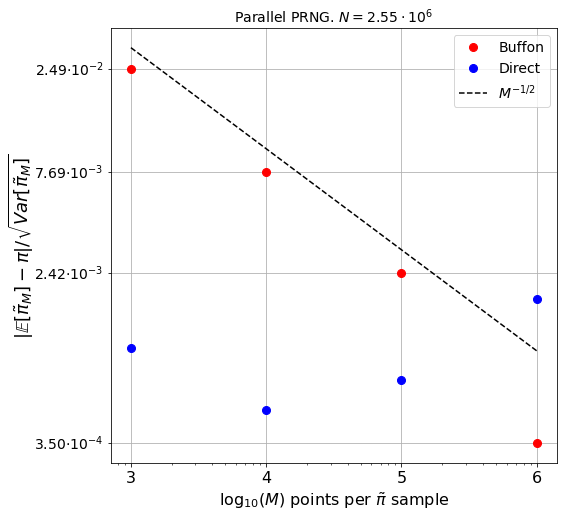

In [216]:
fig = plt.figure(figsize=(8,8))

ax = plt.gca()

ax.plot(ppsBuffonValues, ppsBuffonStandardizedError.to_numpy(), 'ro', ms=8, label="Buffon")
ax.plot(ppsSimpleValues, ppsSimpleStandardizedError, 'bo', ms=8, label="Direct")

ax.plot(ppsBuffonValues, [1.0/np.sqrt(d) for d in ppsBuffonValues], 'k--', label="$M^{-1/2}$")

ax.legend(loc='upper right', fontsize=14)
#ax.set_ylim((lowerBound.min(), upperBound.max()))
ax.set_xlabel("$\log_{10}(M)$ points per $\\tilde{\pi}$ sample", fontsize=16)
ax.set_ylabel("${|\mathbb{E}[ \\tilde{\pi}_M ] - \pi|}/{\sqrt{Var[ \\tilde{\pi}_M ]}}$", fontsize=18, labelpad=-2)


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=2)

ax.set_xticks( ppsBuffonValues )
ax.set_xticklabels( [int(np.log10(item)) for item in ppsBuffonValues], fontsize=16)

#ax.set_yticks( [1.0/np.sqrt(d) for d in ppsValues] )
ax.set_yticks(  ppsBuffonStandardizedError.to_numpy() )
#ax.set_yticklabels( ["$\\frac{1}{\sqrt{" + "{:d}".format(item)+"} }$" for item in ppsValues] )
#ax.set_yticklabels( ["{:.2e}".format(item) for item in  ppsStandardizedError.to_numpy()] )
ax.set_yticklabels( yLabels, fontsize=14, va='center', ha='right' )


ax.yaxis.set_tick_params(labelsize=14)
ax.grid(which='major', axis='x')
ax.grid(which='both', axis='y')

ax.set_title( "Parallel PRNG. $N=2.55\cdot 10^{6}$", fontsize=14)

#fig.savefig("DSMCPI_ConvergenceOfMeanofMeansAndAcceptanceRegion_ToEmpiricalMean_{}.png".format(samplesOnUnitSquare) )
fig.savefig("PI_DSMCvsBUFFON_StandardisedError_PPSdependence.svg" )

## Visualisation of the normalised deviation w.r.t. number of samples

In this section we consider the behaviour of the normalised deviation (approximation error) as a function of the sample size $M=|\lbrace \tilde{\pi}_i\rbrace|$ where each $\tilde{\pi}_i$ is obtained using $10000$ points on either $[0,1]^2$ ($\pi/4$) or $[0,\frac{1}{2})\times[0,\pi/2)$ (Buffon).

In [217]:
prngBuffonCumulativeSum10k = ppsBuffonData['10000'].expanding().mean().to_numpy()
prngSimpleCumulativeSum10k = ppsSimpleData['10000'].expanding().mean().to_numpy()

prngSimpleStds10k = ppsSimpleData['10000'].expanding().std().to_numpy()
prngBuffonStds10k = ppsBuffonData['10000'].expanding().std().to_numpy()

Check how large the dataset is.

In [218]:
prngCumulativeSum10k.shape

(16916400,)

In [219]:
prngBuffonDeviation10k = abs(prngBuffonCumulativeSum10k - np.pi)
prngSimpleDeviation10k = abs(prngSimpleCumulativeSum10k - np.pi)

In [220]:
prngBuffonNormalisedDeviation10k = prngBuffonDeviation10k/prngBuffonStds10k

In [221]:
prngSimpleNormalisedDeviation10k = prngSimpleDeviation10k/prngSimpleStds10k

In [222]:
prngBuffonCumulativeSum100k = ppsBuffonData[samplesOnUnitSquare].expanding().mean().to_numpy()
prngSimpleCumulativeSum100k = ppsSimpleData[samplesOnUnitSquare].expanding().mean().to_numpy()

prngSimpleStds100k = ppsSimpleData[samplesOnUnitSquare].expanding().std().to_numpy()
prngBuffonStds100k = ppsBuffonData[samplesOnUnitSquare].expanding().std().to_numpy()

In [223]:
prngBuffonDeviation100k = abs(prngBuffonCumulativeSum100k - np.pi)
prngSimpleDeviation100k = abs(prngSimpleCumulativeSum100k - np.pi)

In [224]:
prngBuffonNormalisedDeviation100k = prngBuffonDeviation100k/prngBuffonStds100k
prngSimpleNormalisedDeviation100k = prngSimpleDeviation100k/prngSimpleStds100k

Subsample the data to reduce plot time and memory consumption

In [225]:
sampleSizes = np.arange(1, prngBuffonCumulativeSum100k.shape[0], stepSize)

In [226]:
tDOF = len(ppsBuffonData['10000'].to_numpy()) - 1

t_1 = stats.t.ppf(0.01/2, tDOF)
t_2 = stats.t.ppf(1-0.01/2, tDOF)

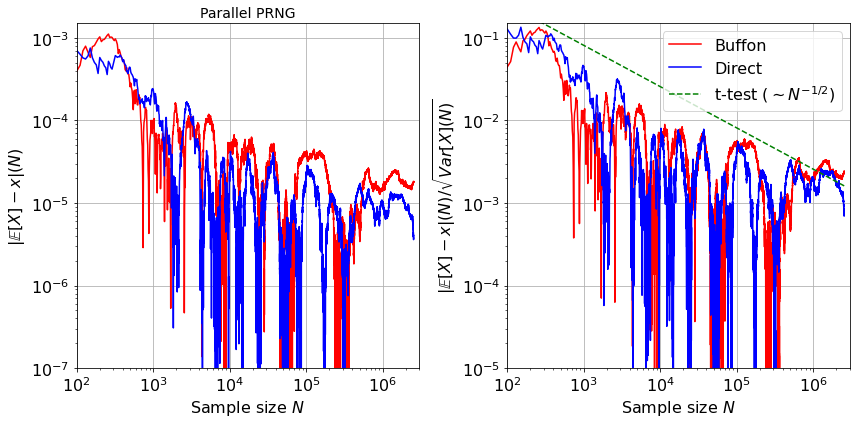

In [227]:
fig, (axl, ax) = plt.subplots(1,2, figsize=(2*6,6), sharex=True)


axl.plot(sampleSizes,prngBuffonDeviation100k[::stepSize], 'r-', label="Buffon")
axl.plot(sampleSizes,prngSimpleDeviation100k[::stepSize],  'b-', label="direct")

ax.plot(sampleSizes,prngBuffonNormalisedDeviation100k[::stepSize], 'r-', label="Buffon")
ax.plot(sampleSizes,prngSimpleNormalisedDeviation100k[::stepSize],  'b-', label="Direct")

ax.plot( sampleSizes, [max(abs(t_1), abs(t_2))/np.sqrt(item) for item in sampleSizes], color='g', linestyle='--', label="t-test $(\sim N^{-1/2})$")

ax.legend(loc='upper right', fontsize=16)

ax.set_xlabel("Sample size $N$", fontsize=16)
axl.set_xlabel("Sample size $N$", fontsize=16)

ax.set_ylabel("$|\mathbb{E}[X] - x|(N)/\sqrt{Var[X](N)}$" ,fontsize=16)
axl.set_ylabel("$|\mathbb{E}[X] - x|(N)$" ,fontsize=16)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

axl.yaxis.set_tick_params(labelsize=16)
axl.xaxis.set_tick_params(labelsize=16)

ax.grid(which='major')
axl.grid(which='major')
ax.set_xscale('log', base=10)
ax.set_xlim((100, 3e6))
ax.set_ylim((1e-5,1.5e-1))

axl.set_ylim((1e-7,1.5e-3))

ax.set_yscale('log', base=10)
axl.set_yscale('log', base=10)

axl.set_title("Parallel PRNG", fontsize=14)
fig.tight_layout()
#fig.suptitle("Parallel PRNG", fontsize=14)


fig.savefig("Pi_DSMCvsBUFFON_StandardizedDeviationFromPi_pps_{:d}.svg".format( int(samplesOnUnitSquare) ) )

We observe that, as shown above, the Buffon approximation exceeds the expected $N^{-1/2}$ bound after $\sim 6\cdot 10^{5}$ samples not to return. In contrast, the simple approximation exceeds the same threshold for the first time at $\sim 1.2\cdot 10^6$ and falls back within the acceptable territory at $\sim 2\cdot 10^6$ samples.
Note that this aligns with the observations for $M=10^5$ points-per-sample made in the preceding section.

## Visualisation of the distributions for Buffon and $\pi/4$ examples

Compute the normalised histograms for $\pi/4$ and Buffon approximations for the entire dataset.

In [228]:
histValuesSimple, binCentresSimple, binEdgesSimple, histErrorbarsSimple = normhist(ppsSimpleData['1000'].to_numpy())
histValuesBuffon, binCentresBuffon, binEdgesBuffon, histErrorbarsBuffon = normhist(ppsBuffonData['1000'].to_numpy())

In [229]:
Nsamples = ppsSimpleData['1000'].to_numpy().shape[0]

Add a normal distribution with parameters being the mean and standard deviation of the Buffon data. 

In [230]:
# add a normal distribution for visualisation purposes
stdBuffon = np.std(ppsBuffonData['1000'].to_numpy(), ddof=1)
meanBuffon = np.average(ppsBuffonData['1000'].to_numpy())

y = np.linspace( min(ppsBuffonData['1000'].to_numpy()), max(ppsBuffonData['1000'].to_numpy()), 100)

p = stats.norm.pdf(y, loc=meanBuffon, scale=stdBuffon)

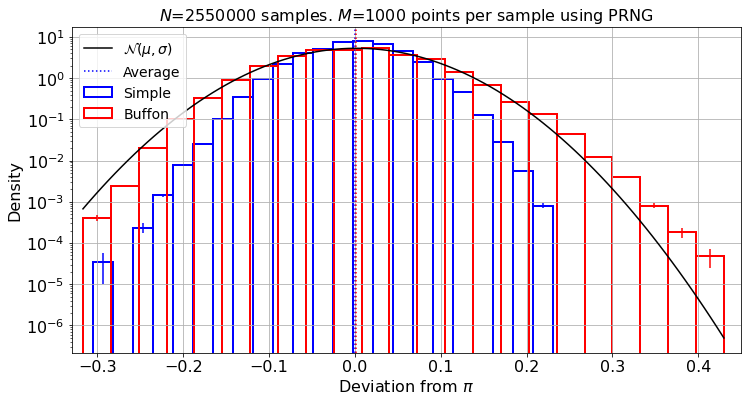

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)

ax.bar(binCentresSimple - np.pi, histValuesSimple, width=binCentresSimple[1] - binCentresSimple[0],  yerr=histErrorbarsSimple, edgecolor='b', ecolor='b', fill=False, linewidth=2,  label="Simple")
ax.bar(binCentresBuffon - np.pi, histValuesBuffon, width=binCentresBuffon[1] - binCentresBuffon[0],  yerr=histErrorbarsBuffon, edgecolor='r', ecolor='r', fill=False, linewidth=2,  label="Buffon")

#normal distribution
ax.plot(y-np.pi, p, 'k-', label="$\mathcal{N}(\mu,\sigma)$")

ax.axvline(ppsSimpleData['1000'].to_numpy().mean()- np.pi, color='b', linestyle=':', label="Average")
ax.axvline(ppsBuffonData['1000'].to_numpy().mean()- np.pi, color='r', linestyle=':')

ax.legend( loc='upper left', fontsize=14)
ax.grid(which='major')

ax.set_yscale('log')

ax.set_xlim((-0.33,0.45))
ax.set_title("$N$={:d} samples.".format(Nsamples)+ " $M$=1000 points per sample using PRNG", fontsize=16)
ax.set_xlabel("Deviation from $\pi$", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
# labels and tick modifiers
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


fig.savefig("DSMCPI_BuffonVsSimple_DeviationDistribution.svg")

As can be observed the simple method (estimation of $\pi/4$ on the unit square) yields a more precise estimate than Buffon's needle. Additionally we observe, considering the skewing of the distributions, that whilst the latter tends to over-estimate the value the former tends to under-estimate it.

## Visualisation of the sign test

Here we apply the sign-test, a statistical test requiring the least amount of assumptions.

In [232]:
#parallel runs
qrngData = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/rawData_accumulated/rawSamples_parallel_QRNG.csv", index_col=0)
prngData = pd.read_csv("/programs/extension/QDice_tests/PiTesting/RUN/rawData_accumulated/rawSamples_parallel_PRNG.csv", index_col=0)

In [233]:
#Overwrite the means with raw samples
case1_means = qrngData.iloc[:,0]
prngcase1_means= prngData.iloc[:,0]

In [234]:
N = case1_means.shape[0]

Define the confidence parameter $\alpha$. The % confidence is $(1-\alpha)\cdot 100$.

In [235]:
alpha=0.0001 # 99.99% confidence or, assuming a normal distribution roughly 4-sigma

In [236]:
x = np.arange(0, N)
y = stats.binom.pmf(x, N, 0.5)

/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [237]:
qrngMeanArray = case1_means.to_numpy()
prngMeanArray = prngcase1_means.to_numpy()

In [238]:
qrngData.columns

Index(['100000', '1000000'], dtype='object')

Consider fractions of the entire dataset to determine how the test results evolve with a growing dataset size.

In [239]:
datasetFractions = [1/4, 1/3, 1/2, 1]

708000
944000


/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)
/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


1416000


/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


2832000


/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


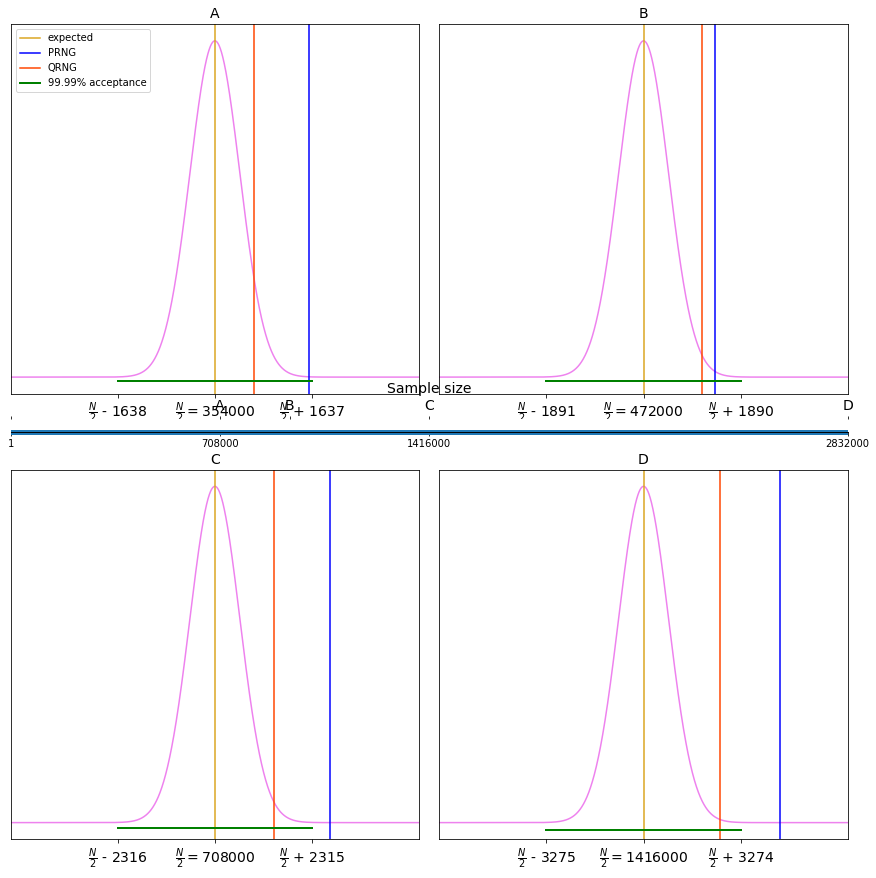

In [240]:
numFractions = len(datasetFractions)

subsetSizes = [ int( np.rint(qrngMeanArray.shape[0] * item ) ) for item in  datasetFractions ]

subplotLabels=["A","B","C","D"]
fig = plt.figure(figsize=(15,15))


#ToDo: change to 2 rows x 3 columns
gs = fig.add_gridspec(3, 2, wspace=0.05, hspace=0.1, height_ratios=[3,0.2,3]) # 3x2 plot

# Layout definition 
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_datasetSize = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])

axList = [ax1, ax2, ax3, ax4]

# Indicating the size of the dataset
ax_datasetSize.axhline(0, linewidth=5)
ax_datasetSize.set_xlim([0, subsetSizes[-1]])
#twin the x axis for subplot labels
axTwin = ax_datasetSize.twiny()
#on the default axis show dataset size
xticksNew = [1, subsetSizes[0], subsetSizes[2], subsetSizes[-1]]
ax_datasetSize.set_xticks(xticksNew)
ax_datasetSize.set_xticklabels(["{:d}".format(item) for item in xticksNew])

axTwin.set_xlim([0, subsetSizes[-1]])
axTwin.spines.bottom.set_position(("axes", 0.5))
axTwin.set_xticks([0]+subsetSizes)
axTwin.set_xticklabels([""] + subplotLabels, fontsize=14)

ax_datasetSize.set_ylim((-1e-3,1e-3))
ax_datasetSize.spines[['bottom']].set_position('center')
ax_datasetSize.spines[['left', 'top', 'right']].set_visible(False)
#axTwin.spines[['bottom']].set_position('center')
axTwin.spines[['left', 'top', 'right']].set_visible(False)
axTwin.set_title("Sample size", fontsize=14)
ax_datasetSize.set_yticks([])

#plot the acceptance criteria for each fraction of the dataset
for idx in range(numFractions):
    subsetSize = int( np.rint(qrngMeanArray.shape[0] * datasetFractions[idx]) )
    print(subsetSize)
    xprime = np.arange(0, subsetSize)
    #binomial distribution CDF
    cdfValues = stats.binom.cdf(xprime, subsetSize, 0.5)
    # binomial test
    qrngMedianDeviations = case1_means[:subsetSize] - np.pi
    prngMedianDeviations = prngcase1_means[:subsetSize] - np.pi
    Q_qrng = np.count_nonzero( qrngMedianDeviations > 0 )
    Q_prng = np.count_nonzero( prngMedianDeviations > 0 )
    
    #Determine the acceptance region
    upperLimit = 1-cdfValues <= alpha/2
    lowerLimit = cdfValues <= alpha/2
    Q_min = np.nonzero(lowerLimit)[0].max()
    Q_max = np.nonzero(upperLimit)[0].min()

    #plot
    yprime = stats.norm.pdf(x, subsetSize/2, np.sqrt(subsetSize)/2)
    
    axList[idx].plot(x,yprime,color='violet')
    
    axList[idx].axvline(subsetSize/2, 0,1, color='goldenrod', label="expected")
    axList[idx].axvline(Q_prng, 0,1, color='blue', label="PRNG")
    axList[idx].axvline(Q_qrng, 0,1, color='orangered', label="QRNG")
    

    axList[idx].set_xlim((Q_min - 1.1*(subsetSize//2 - Q_min), Q_max + 1.1*(-subsetSize//2 + Q_max)))
    
    xticksNew = [Q_min, subsetSize//2, Q_max]
    axList[idx].set_xticks(xticksNew)
    xticklabelsNew=["$\\frac{N}{2}$ -"+" {:d}".format(subsetSize//2 - Q_min), "$\\frac{N}{2}=$"+"{:d}".format(subsetSize//2), "$\\frac{N}{2}$ +"+" {:d}".format(Q_max - subsetSize//2)]
    axList[idx].set_xticklabels(xticklabelsNew, fontsize=14)
    
    axList[idx].set_yticks([])
    
    axList[idx].set_title(subplotLabels[idx], fontsize=14)
    
    #add a green bar indicating the acceptance region
    #transform Q_min, Q_max to figure coordinates
    transformMin = axList[idx].transData.transform( (Q_min, 0))
    transformMax = axList[idx].transData.transform( (Q_max, 0))
    
    transformMin = axList[idx].transAxes.inverted().transform(transformMin)
    transformMax = axList[idx].transAxes.inverted().transform(transformMax)
    
    axList[idx].axhline( -1e-5, transformMin[0], transformMax[0], linewidth=2, color='green', label="99.99% acceptance")

axList[0].legend(loc='upper left')

#fig.savefig("EvolutionOfTheBinomialTest.jpeg", dpi=120)
plt.show()

Visualise the binomial test for cases A, B, D in a row with the dataset size as a line on top.

In [241]:
datasetFractions = [1/4, 1/3, 1/2]

708000


/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


944000


/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


1416000


/mnt/TGT/DatavisVENV_V2/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


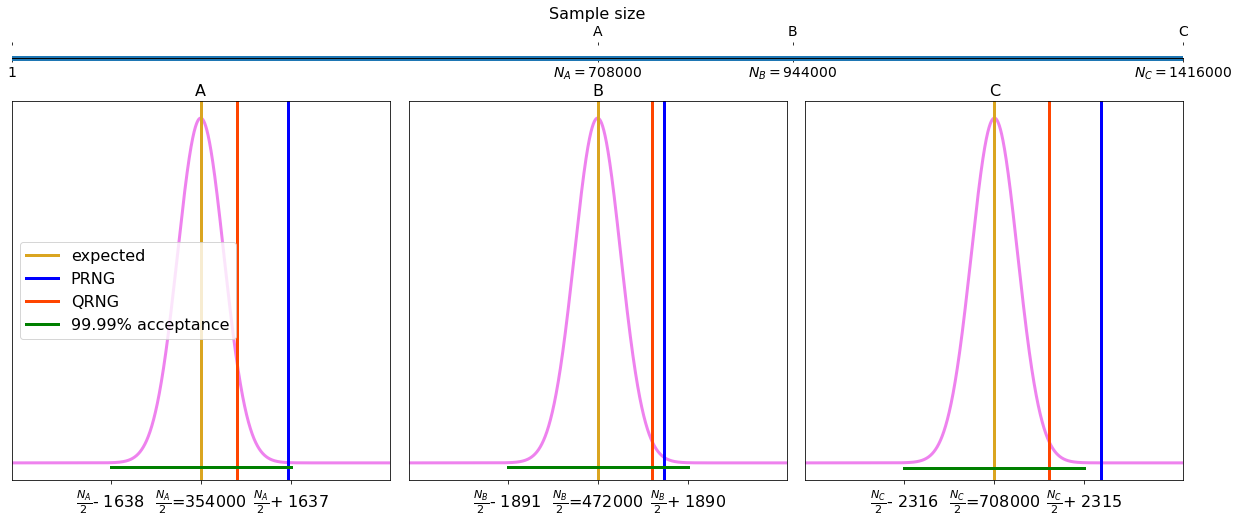

In [242]:
numFractions = len(datasetFractions)

subsetSizes = [ int( np.rint(qrngMeanArray.shape[0] * item ) ) for item in  datasetFractions ]

subplotLabels=["A","B","C"]
#fig = plt.figure(layout='constrained', figsize=(15,15))
fig = plt.figure(figsize=(3*7,7+1))


gs = fig.add_gridspec(2, 3, wspace=0.05, hspace=0.15, height_ratios=[0.2,3])

# Layout definition 
# ToDo: join subplots (0,0) and (0,1) for the indicator of the dataset size
ax_datasetSize = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])
ax3 = fig.add_subplot(gs[1,2])

axList = [ax1, ax2, ax3]

# Indicating the size of the dataset
ax_datasetSize.axhline(0, linewidth=5)
ax_datasetSize.set_xlim([1, subsetSizes[-1]])
#twin the x axis for subplot labels
axTwin = ax_datasetSize.twiny()
#on the default axis show dataset size
xticksNew = [1, subsetSizes[0], subsetSizes[1], subsetSizes[-1]]
datasetSizeLabels = ["", "$N_A=$", "$N_B=$", "$N_C= $"]
ax_datasetSize.set_xticks(xticksNew)
#ax_datasetSize.set_xticklabels(["{:d}".format(item) for item in xticksNew])
ax_datasetSize.set_xticklabels([item[0] + "{:d}".format(item[1]) for item in zip(datasetSizeLabels, xticksNew)])


axTwin.set_xlim([0, subsetSizes[-1]])
axTwin.spines.bottom.set_position(("axes", 0.5))
axTwin.set_xticks([1]+subsetSizes)
axTwin.set_xticklabels([""] + subplotLabels, fontsize=14)

ax_datasetSize.set_ylim((-1e-3,1e-3))
ax_datasetSize.spines[['bottom']].set_position('center')
ax_datasetSize.spines[['left', 'top', 'right']].set_visible(False)
#axTwin.spines[['bottom']].set_position('center')
axTwin.spines[['left', 'top', 'right']].set_visible(False)
axTwin.set_title("Sample size", fontsize=16)
ax_datasetSize.set_yticks([])
ax_datasetSize.xaxis.set_tick_params(labelsize=14)

#plot the acceptance criteria for each fraction of the dataset
for idx in range(numFractions):
    subsetSize = int( np.rint(qrngMeanArray.shape[0] * datasetFractions[idx]) )
    print(subsetSize)
    xprime = np.arange(0, subsetSize)
    #binomial distribution CDF
    cdfValues = stats.binom.cdf(xprime, subsetSize, 0.5)
    # binomial test
    qrngMedianDeviations = case1_means[:subsetSize] - np.pi
    prngMedianDeviations = prngcase1_means[:subsetSize] - np.pi
    Q_qrng = np.count_nonzero( qrngMedianDeviations > 0 )
    Q_prng = np.count_nonzero( prngMedianDeviations > 0 )
    
    #Determine the acceptance region
    upperLimit = 1-cdfValues <= alpha/2
    lowerLimit = cdfValues <= alpha/2
    Q_min = np.nonzero(lowerLimit)[0].max()
    Q_max = np.nonzero(upperLimit)[0].min()

    #plot
    yprime = stats.norm.pdf(x, subsetSize/2, np.sqrt(subsetSize)/2)
    
    axList[idx].plot(x,yprime,color='violet', linewidth=3)
    
    axList[idx].axvline(subsetSize/2, 0,1, color='goldenrod', label="expected", linewidth=3)
    axList[idx].axvline(Q_prng, 0,1, color='blue', label="PRNG", linewidth=3)
    axList[idx].axvline(Q_qrng, 0,1, color='orangered', label="QRNG", linewidth=3)
    
    axList[idx].set_xlim((Q_min - 1.1*(subsetSize//2 - Q_min), Q_max + 1.1*(-subsetSize//2 + Q_max)))
    
    xticksNew = [Q_min, subsetSize//2, Q_max]
    axList[idx].set_xticks(xticksNew)
    # Constructing the size labels
    xticklabelsSizeLabelBase = "$\\frac{N_"+subplotLabels[idx]+"}{2}$"
    xticklabelsNew =[ xticklabelsSizeLabelBase + item for item in ["- {:d}".format(subsetSize//2 - Q_min), "={:d}".format(subsetSize//2), "+ {:d}".format(Q_max - subsetSize//2)] ]
    axList[idx].set_xticklabels(xticklabelsNew, fontsize=16)
    
    axList[idx].set_yticks([])
    
    #axList[idx].grid(which='both')
    axList[idx].set_title(subplotLabels[idx], fontsize=16)
    
    #add a green bar indicating the acceptance region
    #transform Q_min, Q_max to figure coordinates
    transformMin = axList[idx].transData.transform( (Q_min, 0))
    transformMax = axList[idx].transData.transform( (Q_max, 0))
    
    transformMin = axList[idx].transAxes.inverted().transform(transformMin)
    transformMax = axList[idx].transAxes.inverted().transform(transformMax)
    
    axList[idx].axhline( -1e-5, transformMin[0], transformMax[0], linewidth=3, color='green', label="99.99% acceptance")

#
axList[0].legend(loc='center left', fontsize=16)
#fig.tight_layout()

fig.savefig("EvolutionOfTheBinomialTestUpToHalfSampleSize.svg")
#plt.show()

In [243]:
print("Dataset size: ", N)

Dataset size:  2832000


**Conclusions**: Given the above two figures we observe the following:
- Both RNGs yield more $\tilde{\pi}_i$ larger than $\pi$
- Up to a sample size $N\approx 944 000$ of $\tilde{\pi}$ samples both RNGs yield acceptable results
- For sample sizes $N\geq 1.416\cdot 10^6$ PRNG (Mersenne Twister) results fail to stay within the $99.99\%$ acceptance interval and thus **are** statistically significantly different from $\pi$.
- The entire considered dataset of $N=2.832\cdot 10^6$ $\tilde{\pi}$ samples collected using a QRNG yields approximations of $\pi$ that **are not** statistically significantly different from $\pi$.